In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.lines as mlines
from scipy.optimize import curve_fit
import h5py
from pathlib import Path
from collections.abc import Iterable
from matplotlib.colors import LogNorm

In [2]:
datapath = Path.cwd() / "data"

In [3]:
figurepath = Path.cwd().parent / "figures"

In [4]:
W = 5.88    # Figure width in inches, approximately A4-width - 2*1.25in margin
plt.rcParams.update({
    'figure.figsize': (W, W),#/(4/3)),     # 1:1 aspect ratio
    'font.size' : 11,                   # Set font size to 11pt
    'axes.labelsize': 11,               # -> axis labels
    'legend.fontsize': 10,              # -> legends
    'font.family': 'lmodern',
    'text.usetex': True,
    'text.latex.preamble': (            # LaTeX preamble
        r'\usepackage{lmodern}'
        # ... more packages if needed
    )
})

In [5]:
def set_size(width='thesis', fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    aspect_ratio = 1#(5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * aspect_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)


In [6]:
def rearrange_data(arr): #
    res = np.swapaxes(arr,-1,0)
    res = np.swapaxes(res,-2,1)
    return res

def disorder_mean(A, n_samples = None):
    if n_samples is None:
        return np.mean(A,2)
    else:
        return np.mean(A[:,:,0:n_samples],2)

def disorder_std(A, n_samples = None):
    if n_samples is None:
        return np.std(A,2)
    else:
        return np.std(A[:,:,0:n_samples],2)

In [7]:
def idx_transgression(arr,threshold):
    idx = np.zeros(arr.shape[1],dtype=int)
    for j in range(arr.shape[1]):
        found = False
        for i in range(arr.shape[0]):
            if found == False and arr[i,j] >= threshold:
                idx[j] = i
                found = True
        if found == False:
            idx[j] = -1 #be careful that this never breaks things
    return idx

def safeguard_minusone(idx):
    res = np.zeros(idx.shape[0],dtype=float)
    for i in range(idx.shape[0]):
        res[i] = idx[i] if idx[i] != -1 else np.nan
    return res

def mask_transgression(arr,threshold):
    mask = np.zeros(arr.shape,dtype=bool)
    idx = idx_transgression(arr,threshold)
    for j in range(arr.shape[1]):
        if idx[j] != -1:
            mask[idx[j],j]=True
    return mask

def T_transgression(T,arr,threshold):
    idx = idx_transgression(arr,threshold)
    t_past = T[idx]
    t_before = T[[i-1 if i > 0 else 0 for i in idx]]
    arr_past = np.zeros(arr.shape[1])
    arr_before = np.zeros(arr.shape[1])
    t_th = np.zeros(arr.shape[1])
    for j in range(0,arr.shape[1]):
        arr_past[j] = arr[idx[j],j]
        arr_before[j] = arr[idx[j]-1 if idx[j] > 0 else 0,j]

        t_th[j] = (threshold-arr_before[j])/(arr_past[j]-arr_before[j]) * (t_past[j]-t_before[j]) + t_before[j]
    return t_th

In [8]:
jobids = []
params = []
data_xx = []
data_zz = []
folder_xx = datapath/"xx"
folder_zz = datapath/"zz"
files_xx = ["7621756_N19_RS.jld2","7621757_N19_RS.jld2"] #xx_pbc, xx_nn_pbc
files_zz = ["7510084_N19_RS.jld2","7501573_N19_RS.jld2","7728967_N19_RS.jld2","7728968_N19_RS.jld2",
"7621783_N19_RS.jld2","7621758_N19_RS.jld2","7501554_N19_RS.jld2","7466533_N19_RS.jld2","7466536_N19_RS.jld2"] #LOG: zz_pbc, zz_nn_pbc, sector zz_pbc, sector zz_nn_pbc, LIN:alpha = 0.75, 1.5, 3, 6, NN
for (i,file) in enumerate(files_xx):
    with h5py.File(folder_xx/file,"r") as f:
            jobids.append(f["jobid"][()].decode("UTF-8"))
            data_xx.append(2-2*rearrange_data(f["data"][()]))
            params.append(f["params"][()])

for (i,file) in enumerate(files_zz):
    with h5py.File(folder_zz/file,"r") as f:
            jobids.append(f["jobid"][()].decode("UTF-8"))
            data_zz.append(2-2*rearrange_data(f["data"][()]))
            params.append(f["params"][()])
#for  i in range(1,len(files)):
 #       data[i] = np.concatenate(data[i],axis=2)
#T = np.arange(0,2.01,0.01)

In [9]:
N = 19
T = 10 ** np.linspace(-3,1,100)
Tlin = np.arange(0,2.51,0.01)
xcenter = N//2
x = np.arange(0,N//2+1,1)
rvals = np.array([abs(pos-xcenter) for pos in range(0,N)])

In [10]:
def model(x,a,b):
    return a*x**b

In [11]:
data_zz[0].shape

(100, 19, 1)

In [12]:
len(data_zz)

9

# ZZ Commutator

In [13]:
res_zz = data_zz[0][:,:,0]
res_zz_nn = data_zz[1][:,:,0]
red_zz = np.zeros((res_zz.shape[0],N//2+1))
red_zz_nn = np.zeros((res_zz.shape[0],N//2+1))

res_zz_sector = data_zz[2][:,:,0]
res_zz_nn_sector = data_zz[3][:,:,0]
red_zz_sector = np.zeros((res_zz_sector.shape[0],N//2+1))
red_zz_nn_sector = np.zeros((res_zz_sector.shape[0],N//2+1))


res_zz_a075lin = data_zz[-5][:,:,0]
res_zz_a15lin = data_zz[-4][:,:,0]
res_zz_a3lin = data_zz[-3][:,:,0]
res_zz_a6lin = data_zz[-2][:,:,0]
res_zz_nnlin = data_zz[-1][:,:,0]
red_zz_a075lin = np.zeros((res_zz_a075lin.shape[0],N//2+1))
red_zz_a15lin = np.zeros((res_zz_a15lin.shape[0],N//2+1))
red_zz_a3lin = np.zeros((res_zz_a3lin.shape[0],N//2+1))
red_zz_a6lin = np.zeros((res_zz_a6lin.shape[0],N//2+1))
red_zz_nnlin = np.zeros((res_zz_nnlin.shape[0],N//2+1))

for j in range(0,N//2):
    red_zz[:,j] = 0.5*(res_zz[:,j]+res_zz[:,N-j-1])
    red_zz_nn[:,j] = 0.5*(res_zz_nn[:,j]+res_zz_nn[:,N-j-1])
    red_zz_sector[:,j] = 0.5*(res_zz_sector[:,j]+res_zz_sector[:,N-j-1])
    red_zz_nn_sector[:,j] = 0.5*(res_zz_nn_sector[:,j]+res_zz_nn_sector[:,N-j-1])
    red_zz_a075lin[:,j] = 0.5*(res_zz_a075lin[:,j]+res_zz_a075lin[:,N-j-1])
    red_zz_a15lin[:,j] = 0.5*(res_zz_a15lin[:,j]+res_zz_a15lin[:,N-j-1])
    red_zz_a3lin[:,j] = 0.5*(res_zz_a3lin[:,j]+res_zz_a3lin[:,N-j-1])
    red_zz_a6lin[:,j] = 0.5*(res_zz_a6lin[:,j]+res_zz_a6lin[:,N-j-1])
    red_zz_nnlin[:,j] = 0.5*(res_zz_nnlin[:,j]+res_zz_nnlin[:,N-j-1])
red_zz[:,N//2] = res_zz[:,N//2]
red_zz_nn[:,N//2] = res_zz_nn[:,N//2]
red_zz_sector[:,N//2] = res_zz_sector[:,N//2]
red_zz_nn_sector[:,N//2] = res_zz_nn_sector[:,N//2]
red_zz_a075lin[:,N//2] = res_zz_a075lin[:,N//2]
red_zz_a15lin[:,N//2] = res_zz_a15lin[:,N//2]
red_zz_a3lin[:,N//2] = res_zz_a3lin[:,N//2]
red_zz_a6lin[:,N//2] = res_zz_a6lin[:,N//2]
red_zz_nnlin[:,N//2] = res_zz_nnlin[:,N//2]

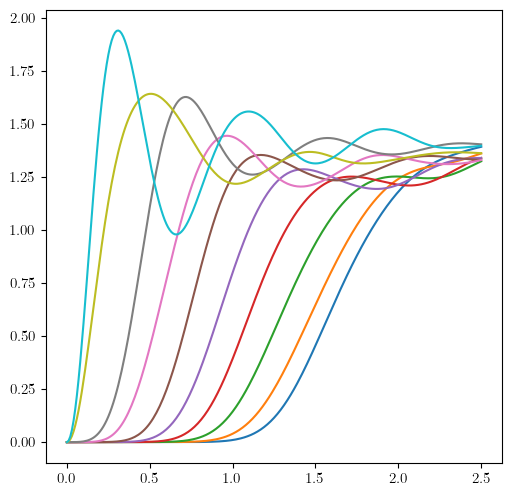

In [14]:
plt.plot(Tlin,red_zz_a6lin)

## Contour Plots

In [15]:
thresholds = [0.1,0.33,0.66]
fit_params075 = []
fit_errs075 = []
tvals075 = []
fit_params15 = []
fit_errs15 = []
tvals15 = []
fit_params3 = []
fit_errs3 = []
tvals3 = []
fit_params6 = []
fit_errs6 = []
tvals6 = []
fit_paramsnn = []
fit_errsnn = []
tvalsnn = []
for (i,th) in enumerate(thresholds):
    tvals075.append(T_transgression(Tlin,res_zz_a075lin,th))
    popt, pcov = curve_fit(model,rvals,tvals075[i])
    fit_params075.append(popt)
    fit_errs075.append(np.sqrt(np.diag(pcov)))

    tvals15.append(T_transgression(Tlin,res_zz_a15lin,th))
    popt, pcov = curve_fit(model,rvals,tvals15[i])
    fit_params15.append(popt)
    fit_errs15.append(np.sqrt(np.diag(pcov)))

    tvals3.append(T_transgression(Tlin,res_zz_a3lin,th))
    popt, pcov = curve_fit(model,rvals,tvals3[i])
    fit_params3.append(popt)
    fit_errs3.append(np.sqrt(np.diag(pcov)))

    tvals6.append(T_transgression(Tlin,res_zz_a6lin,th))
    popt, pcov = curve_fit(model,rvals,tvals6[i])
    fit_params6.append(popt)
    fit_errs6.append(np.sqrt(np.diag(pcov)))

    tvalsnn.append(T_transgression(Tlin,res_zz_nnlin,th))
    popt, pcov = curve_fit(model,rvals,tvalsnn[i])
    fit_paramsnn.append(popt)
    fit_errsnn.append(np.sqrt(np.diag(pcov)))

In [16]:
len(range(0,N))

19

In [17]:
len(Tlin)

251

In [18]:
res_zz_a075lin.shape

(251, 19)

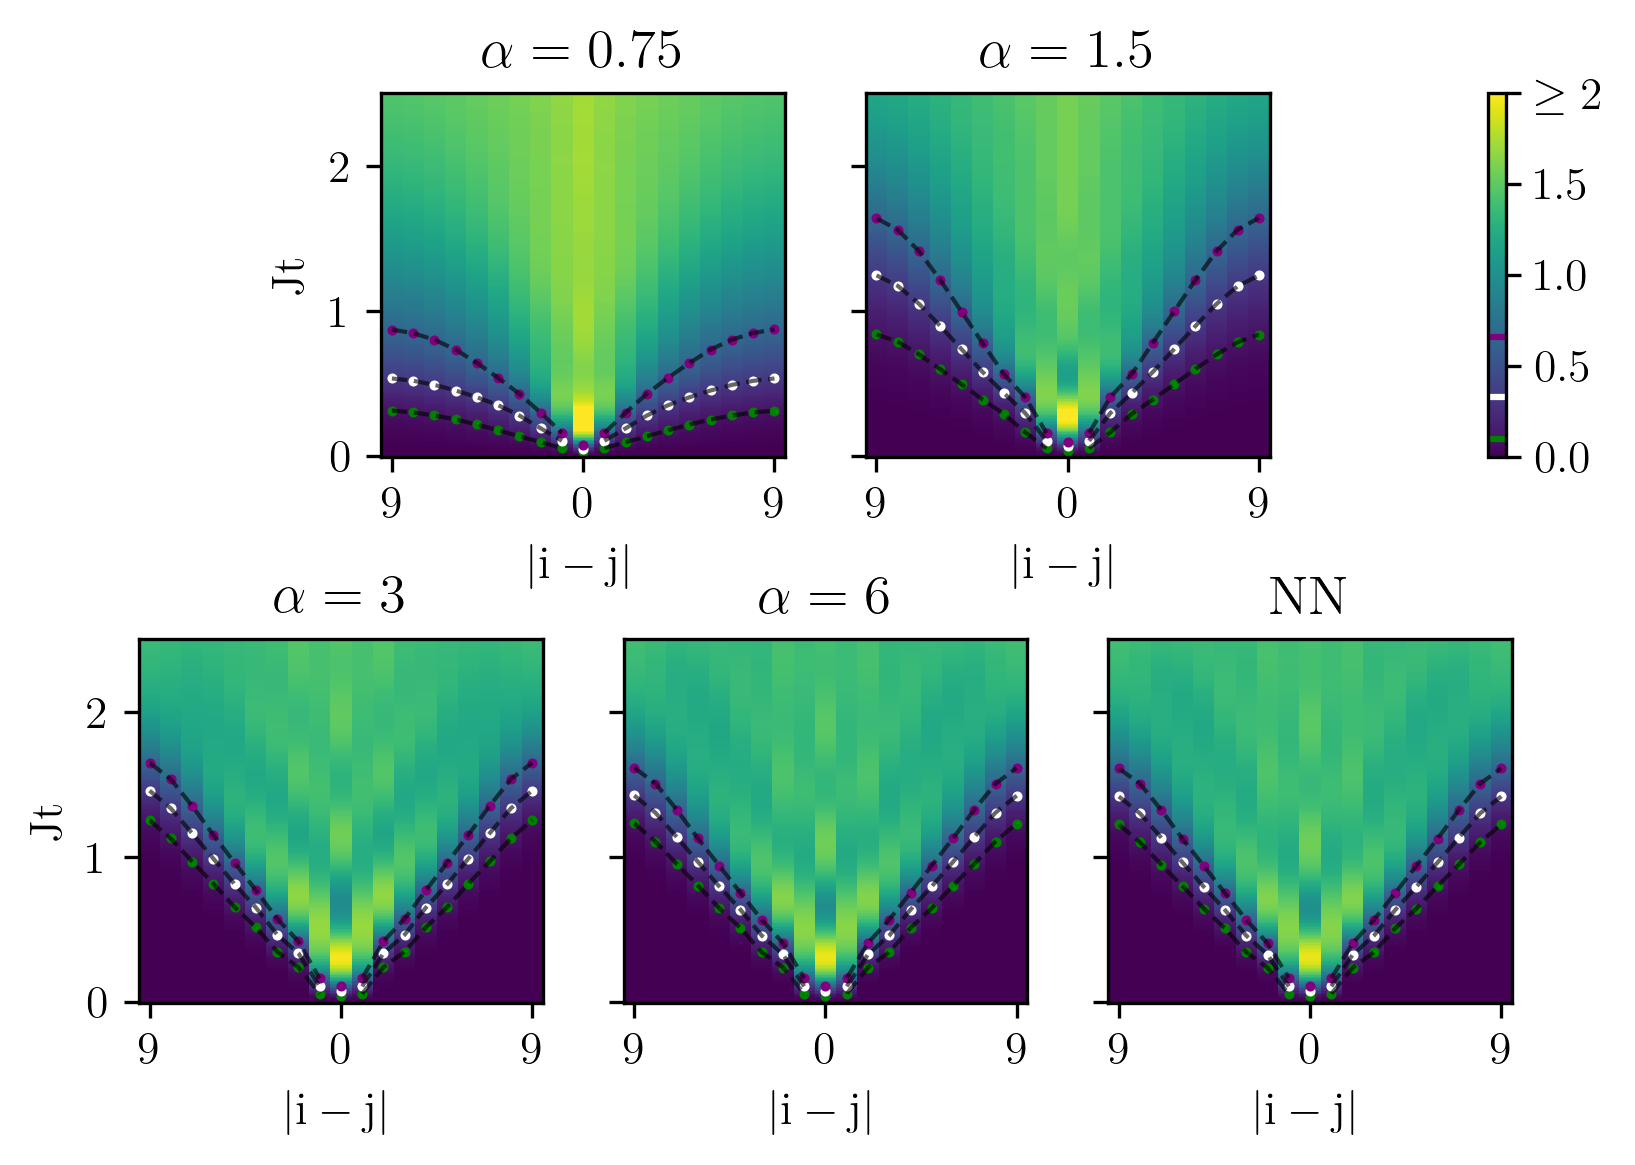

In [19]:
fig = plt.figure(figsize = set_size(subplots=(2,3)),dpi = 300)
gs = gridspec.GridSpec(2, 6,figure=fig)
gs.update(wspace=0.5, hspace=0.5)
ax1 = plt.subplot(gs[0, 1:3])
ax2 = plt.subplot(gs[0, 3:5])
ax3 = plt.subplot(gs[1, 0:2])
ax4 = plt.subplot(gs[1, 2:4])
ax5 = plt.subplot(gs[1, 4:6])
ax_cb = plt.subplot(gs[0, 5])
ax_cb.set_visible(False)

mcolors = ["green","white","purple"]

ax1.pcolormesh(range(0,N),Tlin,res_zz_a075lin[:,:],cmap="viridis",vmin=0,vmax=2)
for (i,th) in enumerate(thresholds):
    ax1.plot(np.arange(0,N//2,1),tvals075[i][:N//2],label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    ax1.plot(np.arange(N//2+1,N,1),tvals075[i][N//2+1:],label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    ax1.scatter(np.arange(0,N,1),tvals075[i], marker= "o", c = mcolors[i], s = 2)
ax1.set_title(r"$\alpha = 0.75$")
ax1.set_ylabel("Jt")
ax1.set_xlabel(r"$\mathrm{|i-j|}$")
ax1.set_xticks([0,N//2,N-1])
ax1.set_xticklabels([9,0,9])


im = ax2.pcolormesh(range(0,N),Tlin,res_zz_a15lin[:,:],cmap="viridis",vmin=0,vmax=2)
for (i,th) in enumerate(thresholds):
    ax2.plot(np.arange(0,N//2,1),tvals15[i][:N//2],label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    ax2.plot(np.arange(N//2+1,N,1),tvals15[i][N//2+1:],label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    ax2.scatter(np.arange(0,N,1),tvals15[i], marker= "o", c = mcolors[i], s = 2)
ax2.set_title(r"$\alpha = 1.5$")
ax2.set_yticklabels([])
ax2.set_xlabel(r"$\mathrm{|i-j|}$")
ax2.set_xticks([0,N//2,N-1])
ax2.set_xticklabels([9,0,9])


ax_cb2 = fig.colorbar(im, ax=ax_cb,ticks=[0,0.5,1,1.5,2]).ax
ax_cb2.plot([0,1],[thresholds[0]]*2,c=mcolors[0])
ax_cb2.plot([0,1],[thresholds[1]]*2,c=mcolors[1])
ax_cb2.plot([0,1],[thresholds[2]]*2,c=mcolors[2])
ax_cb2.set_yticklabels([0.0,0.5,1.0,1.5,r"$\geq 2$"])


ax3.pcolormesh(range(0,N),Tlin,res_zz_a3lin[:,:],cmap="viridis",vmin=0,vmax=2)
for (i,th) in enumerate(thresholds):
    ax3.plot(np.arange(0,N//2,1),tvals3[i][:N//2],label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    ax3.plot(np.arange(N//2+1,N,1),tvals3[i][N//2+1:],label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    ax3.scatter(np.arange(0,N,1),tvals3[i], marker= "o", c = mcolors[i], s = 2)
ax3.set_title(r"$\alpha = 3$")
ax3.set_ylabel("Jt")
ax3.set_xlabel(r"$\mathrm{|i-j|}$")
ax3.set_xticks([0,N//2,N-1])
ax3.set_xticklabels([9,0,9])

ax4.pcolormesh(range(0,N),Tlin,res_zz_a6lin[:,:],cmap="viridis",vmin=0,vmax=2)
for (i,th) in enumerate(thresholds):
    #ax4.plot(np.arange(0,N,1),model(rvals,*fit_params6[i]),label="th = {:.2f}".format(th),color="black",ls="--",lw=1)
    ax4.plot(np.arange(0,N//2,1),tvals6[i][:N//2],label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    ax4.plot(np.arange(N//2+1,N,1),tvals6[i][N//2+1:],label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    ax4.scatter(np.arange(0,N,1),tvals6[i], marker= "o", c = mcolors[i], s = 2)
ax4.set_title(r"$\alpha = 6$")
ax4.set_yticklabels([])
ax4.set_xlabel(r"$\mathrm{|i-j|}$")
ax4.set_xticks([0,N//2,N-1])
ax4.set_xticklabels([9,0,9])


ax5.pcolormesh(range(0,N),Tlin,res_zz_nnlin[:,:],cmap="viridis",vmin=0,vmax=2)
for (i,th) in enumerate(thresholds):
    ax5.plot(np.arange(0,N//2,1),tvalsnn[i][:N//2],label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    ax5.plot(np.arange(N//2+1,N,1),tvalsnn[i][N//2+1:],label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    ax5.scatter(np.arange(0,N,1),tvalsnn[i], marker= "o", c = mcolors[i], s = 2)
ax5.set_title(r"NN")
ax5.set_yticklabels([])
ax5.set_xlabel(r"$\mathrm{|i-j|}$")
ax5.set_xticks([0,N//2,N-1])
ax5.set_xticklabels([9,0,9])


plt.savefig(figurepath/"contours_zz_all.png",format="png",bbox_inches='tight',dpi=600)
plt.show()

## Temporal

In [20]:
popt_zz = []
perr_zz = []
tfitmax = [45,45,35,35,25,25,15,10,10,10]
tfitmin = [0,0,0,0,0,0,0,0,0,0]
tmin = [1,1,1,1,1,1,1,1,1]
for j in range(0,10):
    poptj, pcovj = curve_fit(model,T[tfitmin[j]:tfitmax[j]],red_zz[tfitmin[j]:tfitmax[j],j])
    popt_zz.append(poptj)
    perr_zz.append(np.sqrt(np.diag(pcovj)))

In [21]:
popt_zz

[array([1.09304525e-10, 1.99398640e+00]),
 array([4.34641894e-10, 1.98262163e+00]),
 array([2.31243718e-09, 2.00090802e+00]),
 array([1.47127364e-08, 2.00050712e+00]),
 array([1.31687348e-07, 2.00085788e+00]),
 array([1.94570802e-06, 2.00365795e+00]),
 array([6.16266719e-05, 2.00349573e+00]),
 array([0.00921585, 2.02404603]),
 array([31.98671704,  1.99992902]),
 array([63.88798884,  1.99992129])]

In [22]:
popt_zz_nn = []
perr_zz_nn = []
tfitmax_nn = [60,60,60,60,55,55,50,50,50,50]
tfitmin_nn = [50,50,50,44,37,27,10,0,0,0]
for j in range(0,10):
    poptj_nn, pcovj_nn = curve_fit(model,T[tfitmin_nn[j]:tfitmax_nn[j]],red_zz_nn[tfitmin_nn[j]:tfitmax_nn[j],j])
    popt_zz_nn.append(poptj_nn)
    perr_zz_nn.append(np.sqrt(np.diag(pcovj_nn)))

In [23]:
popt_zz_nn

[array([ 0.10239085, 17.76571191]),
 array([ 0.48041229, 15.69194942]),
 array([ 2.36256732, 13.63712906]),
 array([ 7.0958643 , 11.64894964]),
 array([32.69908628,  9.82222675]),
 array([43.03176216,  7.86292802]),
 array([97.79629097,  5.90941662]),
 array([33.70630537,  4.01601137]),
 array([23.79596712,  1.91121305]),
 array([43.64605274,  1.88547593])]

In [24]:
for j in range(0,9):
    print((popt_zz[j][0]*(9-j)**12-32)/32*100)

-3.528667575840505
-6.661364011494708
0.022209867491129742
0.08257729118565926
0.46947356334572365
2.011136719831086
2.3466879918185635
17.96289204027408
-0.041509258822902684


In [25]:
for j in range(0,9):
    print(perr_zz[j][0]*(9-j)**12)

0.6183818918513541
0.17982788084258197
0.2060654894691305
0.03585221117988451
0.030354002284539418
0.043266256702898215
0.05880396460965502
0.4303456450129796
0.001047491341908477


In [26]:
for j in range(0,10):
    print((popt_zz[j][1]-2)/2*100)

-0.30068006827923544
-0.8689183569572934
0.04540123569185539
0.0253560936640973
0.04289411105302676
0.18289768923436256
0.1747867325326169
1.2023012634648556
-0.0035491655828612245
-0.003935400840204828


In [27]:
tcut_zz = np.zeros(8)
for j in range(0,8):
    tcut_zz[j] = (popt_zz[j][0]/popt_zz_nn[j][0])**(1/(popt_zz_nn[j][1]-popt_zz[j][1]))
    print(tcut_zz[j])

0.26987198345858526
0.21894796955514714
0.16817156610166056
0.12590114671478023
0.0844616483151803
0.055780207740158794
0.02585380748287183
0.016263951005667566


/tmp/ipykernel_158678/1879146936.py:38: RuntimeWarning: divide by zero encountered in double_scalars
  t_th[j] = (threshold-arr_before[j])/(arr_past[j]-arr_before[j]) * (t_past[j]-t_before[j]) + t_before[j]
/tmp/ipykernel_158678/1879146936.py:38: RuntimeWarning: invalid value encountered in double_scalars
  t_th[j] = (threshold-arr_before[j])/(arr_past[j]-arr_before[j]) * (t_past[j]-t_before[j]) + t_before[j]


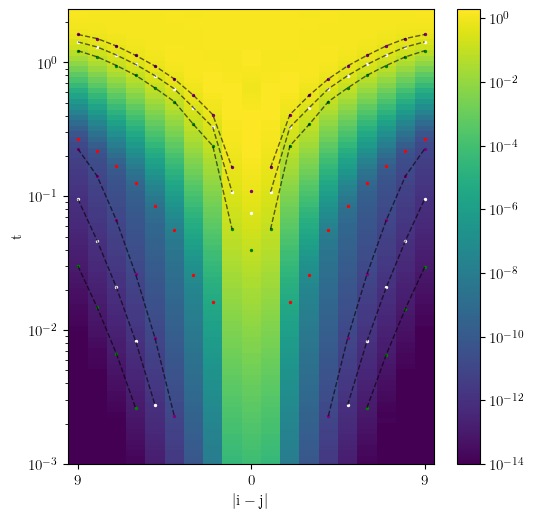

In [28]:
res_zz_safe = np.clip(res_zz,1e-14,2)
thresholds = [1e-13,1e-12,1e-11,0.1,0.33,0.66]

fit_params = []
fit_errs = []
tvals = []
masks = []
for (i,th) in enumerate(thresholds):
    tvals.append(T_transgression(T,res_zz_safe,th))
    masks.append(np.isfinite(tvals[i])) 
    popt, pcov = curve_fit(model,rvals[masks[i]],tvals[i][masks[i]])
    fit_params.append(popt)
    fit_errs.append(np.sqrt(np.diag(pcov)))

mcolors2 = ["green","white","purple"]*2


fig = plt.figure(figsize = set_size())
ax1 = fig.add_subplot(111)
linestyles = ["-","--","-."]
pcm = ax1.pcolormesh(range(0,N),T,res_zz_safe,cmap="viridis",norm=colors.LogNorm(vmin=res_zz_safe.min(),vmax=res_zz_safe.max()))#(res_xx,cmap="viridis",origin="lower",aspect="auto",extent=[0,N,0,T[-1]])
for (i,th) in enumerate(thresholds):
    #ax1.plot(np.arange(0,N,1),model(rvals,*fit_params[i]),label="th = {:.2f}".format(th),color="black",ls="--")
    ax1.plot(np.arange(0,N//2,1),tvals[i][:N//2],label="th = {:.2f}".format(th),color="black",ls="--",lw=1,alpha=0.6)
    ax1.plot(np.arange(N//2+1,N,1),tvals[i][N//2+1:],color="black",ls="--",lw=1,alpha=0.6)
    ax1.scatter(np.arange(0,N,1),tvals[i], marker= "o", c = mcolors2[i], s = 2)
ax1.scatter(np.arange(0,8,1),tcut_zz,marker="o",color="red",s=2)
ax1.scatter(np.arange(8+3,N,1),np.flip(tcut_zz),marker="o",color="red",s=2)
fig.colorbar(pcm,ax=ax1)
ax1.set_xlabel(r"$\mathrm{|i-j|}$")
ax1.set_xticks([0,N//2,N-1])
ax1.set_xticklabels([9,0,9])
ax1.set_yscale("log")
ax1.set_ylabel("t")
#plt.colorbar()
#ax1.legend()
#plt.autoscale('tight')
ax1.set_ylim(1e-3,2.5e0)
plt.show()

/tmp/ipykernel_158678/1879146936.py:38: RuntimeWarning: divide by zero encountered in double_scalars
  t_th[j] = (threshold-arr_before[j])/(arr_past[j]-arr_before[j]) * (t_past[j]-t_before[j]) + t_before[j]
/tmp/ipykernel_158678/1879146936.py:38: RuntimeWarning: invalid value encountered in double_scalars
  t_th[j] = (threshold-arr_before[j])/(arr_past[j]-arr_before[j]) * (t_past[j]-t_before[j]) + t_before[j]


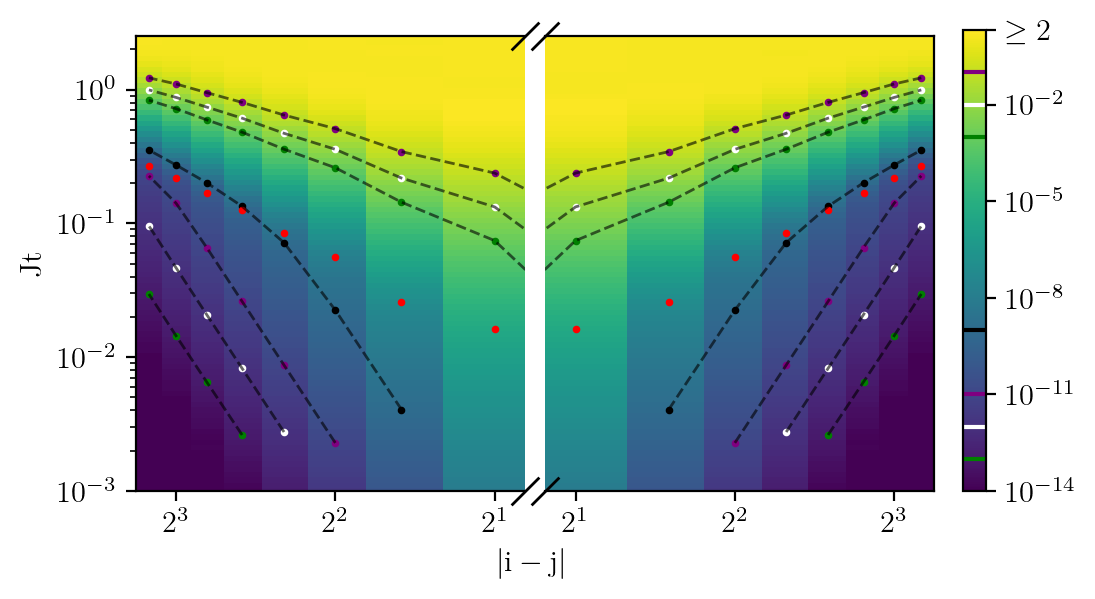

In [29]:
res_zz_safe = np.clip(res_zz,1e-14,2)
thresholds = [1e-13,1e-12,1e-11,1e-3,1e-2,1e-1,1e-9]

fit_params = []
fit_errs = []
tvals = []
masks = []
for (i,th) in enumerate(thresholds):
    tvals.append(T_transgression(T,res_zz_safe,th))
    masks.append(np.isfinite(tvals[i])) 
    popt, pcov = curve_fit(model,rvals[masks[i]],tvals[i][masks[i]])
    fit_params.append(popt)
    fit_errs.append(np.sqrt(np.diag(pcov)))

mcolors2 = ["green","white","purple"]*2

fig, axes = plt.subplots(1,2,figsize = set_size(subplots=(1,2)),dpi=200)
ax1 = axes[0]
ax2 = axes[1]


ax1.pcolormesh(rvals[N//2+1:],T,res_zz_safe[:,N//2+1:],cmap="viridis",norm=colors.LogNorm(vmin=res_zz_safe.min(),vmax=res_zz_safe.max()))#(res_xx,cmap="viridis",origin="lower",aspect="auto",extent=[0,N,0,T[-1]])
for (i,th) in enumerate(thresholds):
    if i==6:
        ax1.plot(rvals[N//2+1:],tvals[i][N//2+1:],color="black",ls="--",lw=1,alpha=0.6)
        ax1.scatter(rvals[N//2+1:],tvals[i][N//2+1:], marker= "o", c = "black", s = 3)
    else:
        #ax1.plot(np.arange(0,N,1),model(rvals,*fit_params[i]),label="th = {:.2f}".format(th),color="black",ls="--")
        ax1.plot(rvals[N//2+1:],tvals[i][N//2+1:],color="black",ls="--",lw=1,alpha=0.6)
        ax1.scatter(rvals[N//2+1:],tvals[i][N//2+1:], marker= "o", c = mcolors2[i], s = 3)
ax1.scatter(rvals[N//2+2:],np.flip(tcut_zz),marker="o",color="red",s=3)
ax1.invert_xaxis()

ax1.set_xscale("log",base=2)
ax1.set_xlim(N//2+0.5,2-0.25)
#ax1.set_xticks([0,N//2,N-1])
#ax1.set_xticklabels([9,0,9])
ax1.set_yscale("log")
ax1.set_ylabel("Jt")
#plt.colorbar()
#ax1.legend()
#plt.autoscale('tight')
ax1.set_ylim(1e-3,2.5e0)



pcm = ax2.pcolormesh(rvals[N//2+1:],T,res_zz_safe[:,N//2+1:],cmap="viridis",norm=colors.LogNorm(vmin=res_zz_safe.min(),vmax=2))#(res_xx,cmap="viridis",origin="lower",aspect="auto",extent=[0,N,0,T[-1]])
for (i,th) in enumerate(thresholds):
    if i==6:
        ax2.plot(rvals[N//2+1:],tvals[i][N//2+1:],color="black",ls="--",lw=1,alpha=0.6)
        ax2.scatter(rvals[N//2+1:],tvals[i][N//2+1:], marker= "o", c = "black", s = 3)
    else:
    #ax1.plot(np.arange(0,N,1),model(rvals,*fit_params[i]),label="th = {:.2f}".format(th),color="black",ls="--")
        ax2.plot(rvals[N//2+1:],tvals[i][N//2+1:],color="black",ls="--",lw=1,alpha=0.6)
        ax2.scatter(rvals[N//2+1:],tvals[i][N//2+1:], marker= "o", c = mcolors2[i], s = 3)
ax2.scatter(rvals[N//2+2:],np.flip(tcut_zz),marker="o",color="red",s=3)

ax2.set_xscale("log",base=2)
ax2.set_xlim(2-0.25,N//2+0.5)
#ax1.set_xticks([0,N//2,N-1])
#ax1.set_xticklabels([9,0,9])
ax2.set_yscale("log")
ax2.set_yticklabels([])
ax2.set_yticks([])
ax2.set_yticks([], minor=True)
#plt.colorbar()
#ax1.legend()
#plt.autoscale('tight')
ax2.set_ylim(1e-3,2.5e0)


plt.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.90, 0.11, 0.05, 0.78])
cbar = fig.colorbar(pcm,ax=cbar_ax,fraction=2.5,pad=0.5,ticks=[1e-14,1e-11,1e-8,1e-5,1e-2,2e0]).ax
cbar_ax.set_visible(False)
cbar.plot([0,1],[thresholds[0]]*2,c=mcolors2[0])
cbar.plot([0,1],[thresholds[1]]*2,c=mcolors2[1])
cbar.plot([0,1],[thresholds[2]]*2,c=mcolors2[2])
cbar.plot([0,1],[thresholds[3]]*2,c=mcolors2[3])
cbar.plot([0,1],[thresholds[4]]*2,c=mcolors2[4])
cbar.plot([0,1],[thresholds[5]]*2,c=mcolors2[5])
cbar.plot([0,1],[thresholds[6]]*2,c="black")
cbar.set_yticklabels([r"$10^{-14}$",r"$10^{-11}$",r"$10^{-8}$",r"$10^{-5}$",r"$10^{-2}$",r"$\geq 2$"])




ax1.spines.right.set_visible(False)
ax2.spines.left.set_visible(False)


d = 1  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=10,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([1, 1], [0, 1], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 0], [0, 1], transform=ax2.transAxes, **kwargs)

ax1.text(1.025,-0.16,r"$\mathrm{|i-j|}$",ha="center",va="center",transform=ax1.transAxes)#,fontsize="xx-small")
plt.subplots_adjust(wspace=0.05)

plt.savefig(figurepath/"lc_regimes.png",format="png",bbox_inches='tight',dpi=600)
plt.show()

In [30]:
fit_params

[array([5.21034306e-08, 6.03480568e+00]),
 array([1.52830677e-07, 6.07412333e+00]),
 array([5.61788012e-06, 4.83453108e+00]),
 array([0.03174388, 1.49682298]),
 array([0.05553835, 1.32230778]),
 array([0.10394191, 1.13084106]),
 array([1.11188455e-03, 2.63517766e+00])]

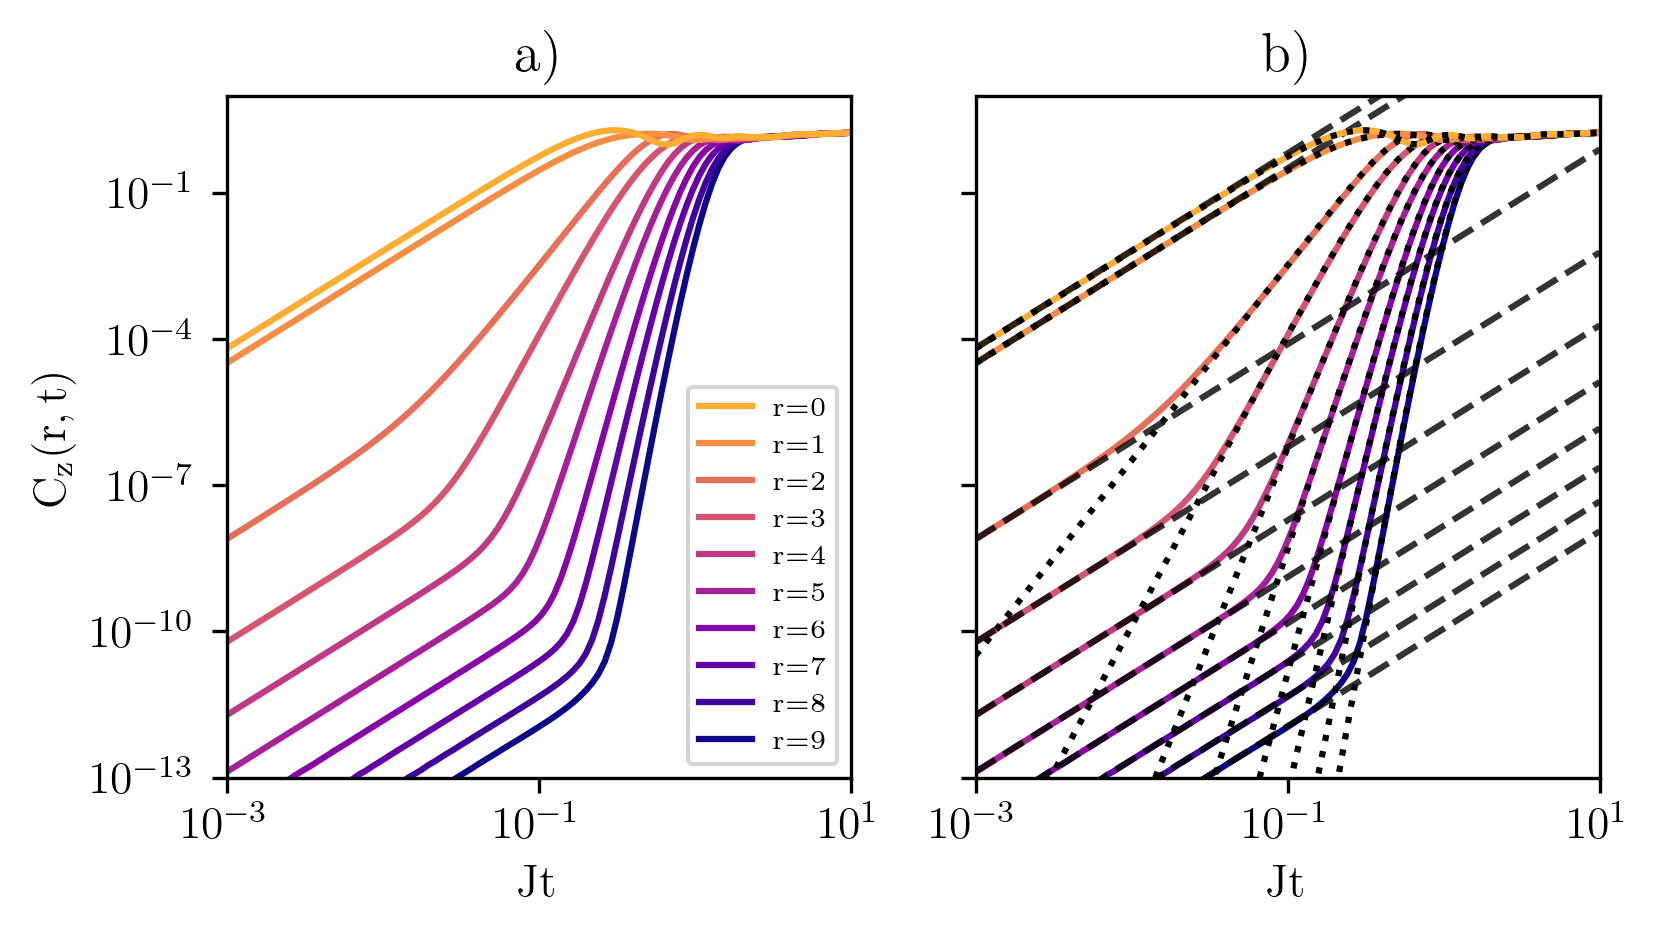

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=set_size(subplots=(1,2)),dpi=300,sharey=True)

NUM_COLORS = N//2+2
cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
ax1.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)])
ax1.set_xscale("log")
ax1.set_yscale("log")
for j in range(0,N//2+1):
    ax1.plot(T,red_zz[:,j],label="r={}".format(rvals[j]))

handles, labels = ax1.get_legend_handles_labels()
order = np.flip(np.arange(0,N//2+1,1))
ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize="xx-small")
ax1.set_xlabel(r"Jt")
ax1.set_ylabel(r"$\mathrm{C_z(r,t)}$")
ax1.set_xlim(1e-3,10)
ax1.set_ylim(1e-13,10)
ax1.set_title("a)")



NUM_COLORS = N//2+2
cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
ax2.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)])
ax2.set_xscale("log")
ax2.set_yscale("log")
for j in range(0,N//2+1):
    ax2.plot(T,red_zz[:,j],label="r={}".format(rvals[j]))
    ax2.plot(T,red_zz_nn[:,j],c="black",ls="dotted")
    if j < 9:
        ax2.plot(T[tfitmin[j]:],32*(T[tfitmin[j]:])**2/(9-j)**12,color="black",alpha=0.8,ls="dashed")
        #ax2.plot(T[tfitmin[j]:],model(T[tfitmin[j]:],popt_zz[j][0],popt_zz[j][1]),color="black",alpha=0.8,ls="dashed")
    if j == 9:
        ax2.plot(T[tfitmin[j]:],65*(T[tfitmin[j]:])**2,color="black",alpha=0.8,ls="dashed")
    #if j <= 9:
        #ax2.plot(T[tfitmin_nn[j]:tfitmax_nn[j]],model(T[tfitmin_nn[j]:tfitmax_nn[j]],popt_zz_nn[j][0],popt_zz_nn[j][1]),color="black",alpha=0.8,ls="dotted")
        #ax2.scatter(tcut_zz[j],model(tcut_zz[j],popt_zz[j][0],popt_zz[j][1]),marker="x",c="black")

handles, labels = plt.gca().get_legend_handles_labels()
order = np.flip(np.arange(0,N//2+1,1))
#ax2.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
ax2.set_xlabel(r"Jt")
#ax2.set_ylabel(r"$\mathrm{C_z(r,t)}$")
ax2.set_xlim(1e-3,10)
ax2.set_ylim(1e-13,10)
ax2.set_title("b)")
plt.savefig(figurepath/"temp_zz.png",format="png",bbox_inches='tight',dpi=600)
plt.show()

In [32]:
T[10]

0.0025353644939701114

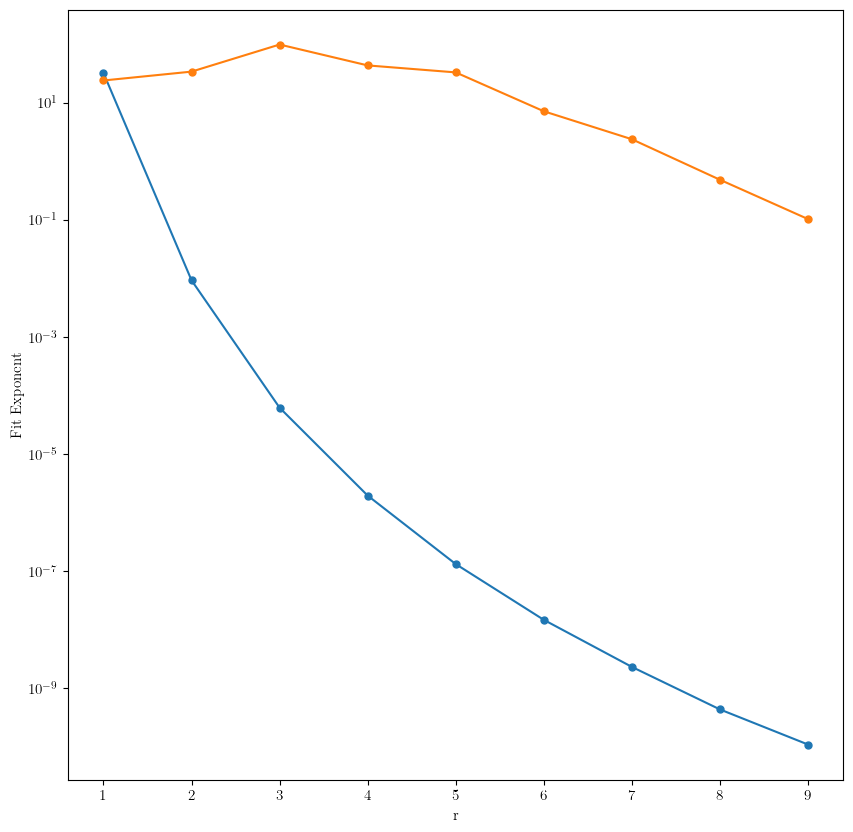

In [33]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(rvals[0:9],[popt_zz[j][0] for j in range(0,9)],marker="o",ms=5)
ax.plot(rvals[0:9],[popt_zz_nn[j][0] for j in range(0,9)],marker="o",ms=5)
ax.set_ylabel("Fit Exponent")
ax.set_yscale("log")
ax.set_xlabel("r")
plt.show()

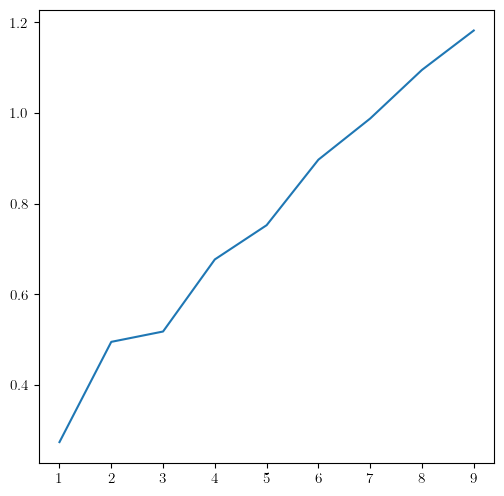

In [34]:
plt.plot(rvals[0:9],[(2/popt_zz_nn[j][0])**(1/popt_zz_nn[j][1]) for j in range(0,9)])

In [35]:
fit = curve_fit(model,rvals[0:8],tcut_zz)[0]

In [36]:
fit

array([0.00369192, 1.9580407 ])

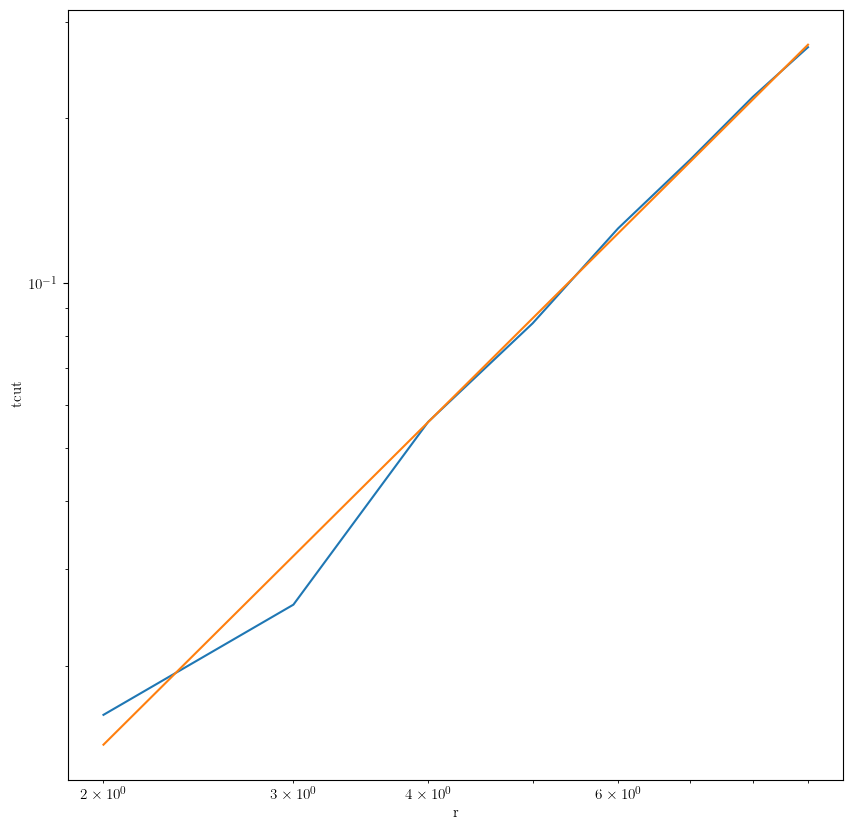

In [37]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.loglog(rvals[0:8],tcut_zz)
ax.loglog(rvals[0:8],model(rvals[0:8],*fit))
ax.set_ylabel("tcut")
ax.set_xlabel("r")
plt.show()

In [38]:
tcut

NameError: name 'tcut' is not defined

## Spatial

/tmp/ipykernel_158678/3249437526.py:14: RuntimeWarning: divide by zero encountered in true_divide
  ax1.plot(rvals[0:10],32/rvals[0:10]**12 * T[ti]**2,color="red",ls="dashed",lw=0.5)
/tmp/ipykernel_158678/3249437526.py:39: RuntimeWarning: divide by zero encountered in true_divide
  ax2.plot(rvals[0:10],32/rvals[0:10]**12 * T[ti]**2,color="red",ls="dashed",lw=0.5)


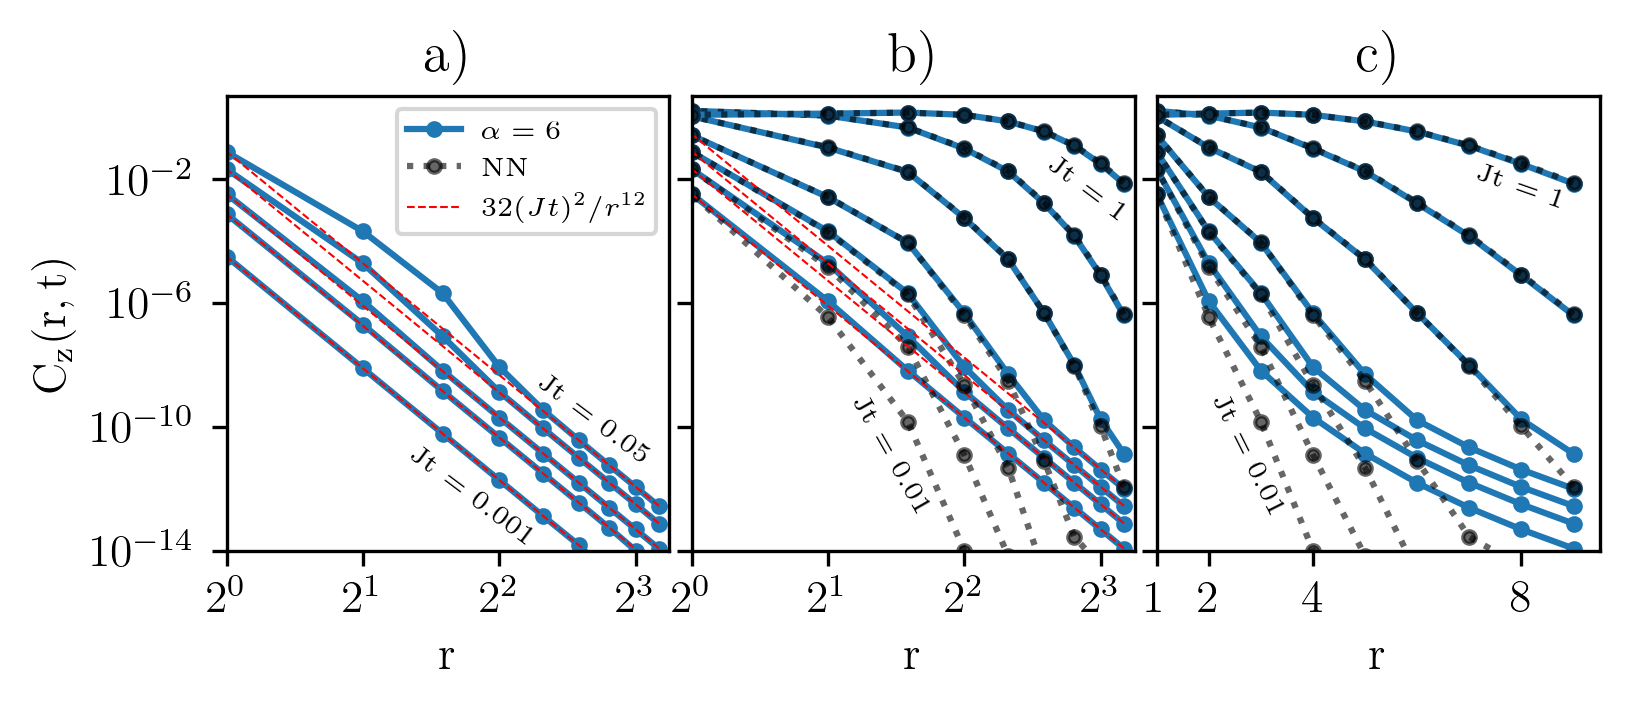

In [39]:
ts1 = [0.001,0.005,0.01,0.025,0.05]
Tis1 = []
for t in ts1:
    Tis1.append(np.argmin(np.abs(T-t)))

ts2 = [0.01,0.025,0.05,0.1,0.25,0.5,1]
Tis2 = []
for t in ts2:
    Tis2.append(np.argmin(np.abs(T-t)))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=set_size(subplots=(1,3)),dpi=300,sharey=True)
for ti in Tis1:
    ax1.plot(rvals[0:10],red_zz[ti,:],label="t={:.2f}".format(T[ti]),color="C0",marker=".")
    ax1.plot(rvals[0:10],32/rvals[0:10]**12 * T[ti]**2,color="red",ls="dashed",lw=0.5)

ax1.set_xlabel("r")
ax1.set_xscale("log",base=2)
ax1.set_yscale("log")
ax1.set_ylabel(r"$\mathrm{C_z(r,t)}$")
ax1.set_ylim(1e-14,5)
ax1.set_xlim(1,N//2+0.5)
ax1.set_xticks([1,2,4,8])
ax1.set_title("a)")
ax1.text(3.5,5e-13,"Jt = {}".format(ts1[0]),rotation=np.arctan(-0.75)/(2*np.pi)*360,ha="center",va="center",fontsize="xx-small")
ax1.text(6.5,1.5e-10,"Jt = {}".format(ts1[-1]),rotation=np.arctan(-0.75)/(2*np.pi)*360,ha="center",va="center",fontsize="xx-small")

blue_line = mlines.Line2D([], [], color='C0', marker='.', label=r"$\alpha=6$")
black_line = mlines.Line2D([], [], color='black', ls="dotted", marker='.', label=r"NN",alpha=0.6)
red_line = mlines.Line2D([], [], color='red', ls="dashed", label=r"$32(Jt)^2/r^{12}$",lw=0.5)

ax1.legend(handles = [blue_line,black_line,red_line],fontsize="xx-small",loc="best")


ind = 0
for ti in Tis2:
    ax2.plot(rvals[0:10],red_zz[ti,:],label="t={:.2f}".format(T[ti]),color="C0",marker=".")
    ax2.plot(rvals[0:10],red_zz_nn[ti,:],ls="dotted",c="black",alpha=0.6,marker=".")
    if ind <= 3:
        ax2.plot(rvals[0:10],32/rvals[0:10]**12 * T[ti]**2,color="red",ls="dashed",lw=0.5)
        ind += 1

ax2.set_xlabel("r")
ax2.set_xscale("log",base=2)
ax2.set_yscale("log")
ax2.set_xlim(1,N//2+0.5)
ax2.set_xticks([1,2,4,8])
ax2.set_title("b)")
ax2.text(2.75,1e-11,"Jt = {}".format(ts2[0]),rotation=np.arctan(-1.75)/(2*np.pi)*360,ha="center",va="center",fontsize="xx-small")
ax2.text(7.5,4e-3,"Jt = {}".format(ts2[-1]),rotation=np.arctan(-0.75)/(2*np.pi)*360,ha="center",va="center",fontsize="xx-small")



for ti in Tis2:
    ax3.plot(rvals[0:10],red_zz[ti,:],label="t={:.2f}".format(T[ti]),color="C0",marker=".")
    ax3.plot(rvals[0:10],red_zz_nn[ti,:],ls="dotted",c="black",alpha=0.6,marker=".")
    
ax3.set_xlabel("r")
ax3.set_yscale("log")
ax3.set_xlim(1,N//2+0.5)
ax3.set_xticks([1,2,4,8])
ax3.set_title("c)")
ax3.text(2.75,1e-11,"Jt = {}".format(ts2[0]),rotation=np.arctan(-2)/(2*np.pi)*360,ha="center",va="center",fontsize="xx-small")
ax3.text(8,5e-3,"Jt = {}".format(ts2[-1]),rotation=np.arctan(-0.35)/(2*np.pi)*360,ha="center",va="center",fontsize="xx-small")


plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.savefig(figurepath/"spat_zz.png",format="png",bbox_inches='tight',dpi=600)
plt.show()

# ZZ Sector

In [40]:
popt_zz_sector = []
perr_zz_sector = []
tfitmax = [45,45,35,35,25,25,15,10,10,10]
tfitmin = [0,0,0,0,0,0,0,0,0,0]
tmin = [1,1,1,1,1,1,1,1,1]
for j in range(0,10):
    poptj, pcovj = curve_fit(model,T[tfitmin[j]:tfitmax[j]],red_zz_sector[tfitmin[j]:tfitmax[j],j])
    popt_zz_sector.append(poptj)
    perr_zz_sector.append(np.sqrt(np.diag(pcovj)))

In [41]:
for j in range(0,9):
    print(popt_zz_sector[j][0]*(9-j)**12/(popt_zz[j][0]*(9-j)**12))

0.9918603452455058
1.0537529367398824
1.035943263694855
1.0520030970117447
1.0571833286017747
1.0561168490660382
1.0580928493499497
1.0561132477787367
1.0502570812519842


<ErrorbarContainer object of 3 artists>

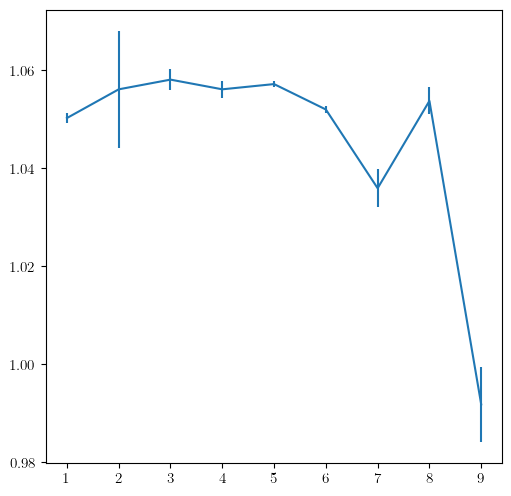

In [42]:
plt.errorbar(rvals[:N//2],[popt_zz_sector[j][0]/(popt_zz[j][0]) for j in range(9)],yerr=[np.sqrt((perr_zz_sector[j][0]/popt_zz[j][0])**2+(popt_zz_sector[j][0]/popt_zz[j][0] * perr_zz[j][0])**2) for j in range(9)])

In [43]:
for j in range(0,9):
    print(popt_zz_sector[j][0]*(9-j)**12)

30.619548507046655
31.473875770938342
33.15754705027216
33.691898005518276
33.988688795061066
34.475417690301704
34.653535590013945
39.86629536960843
33.594276074298286


In [44]:
for j in range(0,9):
    print(perr_zz[j][0]*(9-j)**12)

0.6183818918513541
0.17982788084258197
0.2060654894691305
0.03585221117988451
0.030354002284539418
0.043266256702898215
0.05880396460965502
0.4303456450129796
0.001047491341908477


In [45]:
popt_zz_nn_sector = []
perr_zz_nn_sector = []
tfitmax_nn = [65,65,60,60,55,55,50,50,50,50]
tfitmin_nn = [57,54,50,44,37,27,10,0,0,0]
for j in range(0,10):
    poptj_nn, pcovj_nn = curve_fit(model,T[tfitmin_nn[j]:tfitmax_nn[j]],red_zz_nn_sector[tfitmin_nn[j]:tfitmax_nn[j],j])
    popt_zz_nn_sector.append(poptj_nn)
    perr_zz_nn_sector.append(np.sqrt(np.diag(pcovj_nn)))

In [46]:
tcut_zz_sector = np.zeros(9)
for j in range(0,9):
    tcut_zz_sector[j] = (popt_zz_sector[j][0]/popt_zz_nn_sector[j][0])**(1/(popt_zz_nn_sector[j][1]-popt_zz_sector[j][1]))
    print(tcut_zz_sector[j])

0.2649720591150787
0.21378013374483312
0.16582940850522784
0.12453624286426654
0.0834245314929116
0.0552777649040855
0.025529634952865907
0.016298550414750364
0.03679078542041731


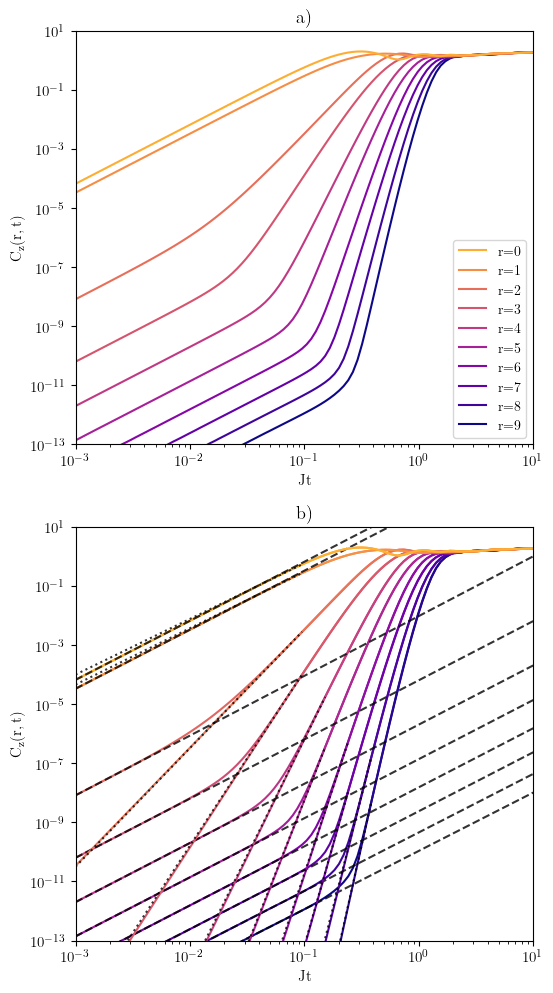

In [47]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=set_size(subplots=(2,1)))

NUM_COLORS = N//2+2
cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
ax1.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)])
ax1.set_xscale("log")
ax1.set_yscale("log")
for j in range(0,N//2+1):
    ax1.plot(T,red_zz_sector[:,j],label="r={}".format(rvals[j]))

handles, labels = ax1.get_legend_handles_labels()
order = np.flip(np.arange(0,N//2+1,1))
ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
ax1.set_xlabel(r"Jt")
ax1.set_ylabel(r"$\mathrm{C_z(r,t)}$")
ax1.set_xlim(1e-3,10)
ax1.set_ylim(1e-13,10)
ax1.set_title("a)")



NUM_COLORS = N+4
cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
ax2.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)])
ax2.set_xscale("log")
ax2.set_yscale("log")
for j in range(0,N//2+1):
    ax2.plot(T,red_zz_sector[:,j],label="r={}".format(rvals[j]))
    ax2.plot(T,red_zz_nn_sector[:,j])
    if j <= 9:
        ax2.plot(T[tfitmin[j]:],model(T[tfitmin[j]:],popt_zz_sector[j][0],popt_zz_sector[j][1]),color="black",alpha=0.8,ls="dashed")
    if j <= 9:
        ax2.plot(T[tfitmin_nn[j]:tfitmax_nn[j]],model(T[tfitmin_nn[j]:tfitmax_nn[j]],popt_zz_nn_sector[j][0],popt_zz_nn_sector[j][1]),color="black",alpha=0.8,ls="dotted")
        #ax2.scatter(tcut_zz[j],model(tcut_zz[j],popt_zz[j][0],popt_zz[j][1]),marker="x",c="black")

handles, labels = plt.gca().get_legend_handles_labels()
order = np.flip(np.arange(0,N//2+1,1))
#ax2.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
ax2.set_xlabel(r"Jt")
ax2.set_ylabel(r"$\mathrm{C_z(r,t)}$")
ax2.set_xlim(1e-3,10)
ax2.set_ylim(1e-13,10)
ax2.set_title("b)")
#plt.savefig(figurepath/"temp_xx.pdf",format="pdf",bbox_inches='tight',dpi=600)
plt.show()

# XX Commutator

In [48]:
res_xx = data_xx[0][:,:,0]
res_xx_nn = data_xx[1][:,:,0]
red_xx = np.zeros((res_xx.shape[0],N//2+1))
red_xx_nn = np.zeros((res_xx.shape[0],N//2+1))

for j in range(0,N//2):
    red_xx[:,j] = 0.5*(res_xx[:,j]+res_xx[:,N-j-1])
    red_xx_nn[:,j] = 0.5*(res_xx_nn[:,j]+res_xx_nn[:,N-j-1])
red_xx[:,N//2] = res_xx[:,N//2]
red_xx_nn[:,N//2] = res_xx_nn[:,N//2]

## Contour Plots

In [49]:
Tlin = np.arange(0,2.5+0.01,0.01)

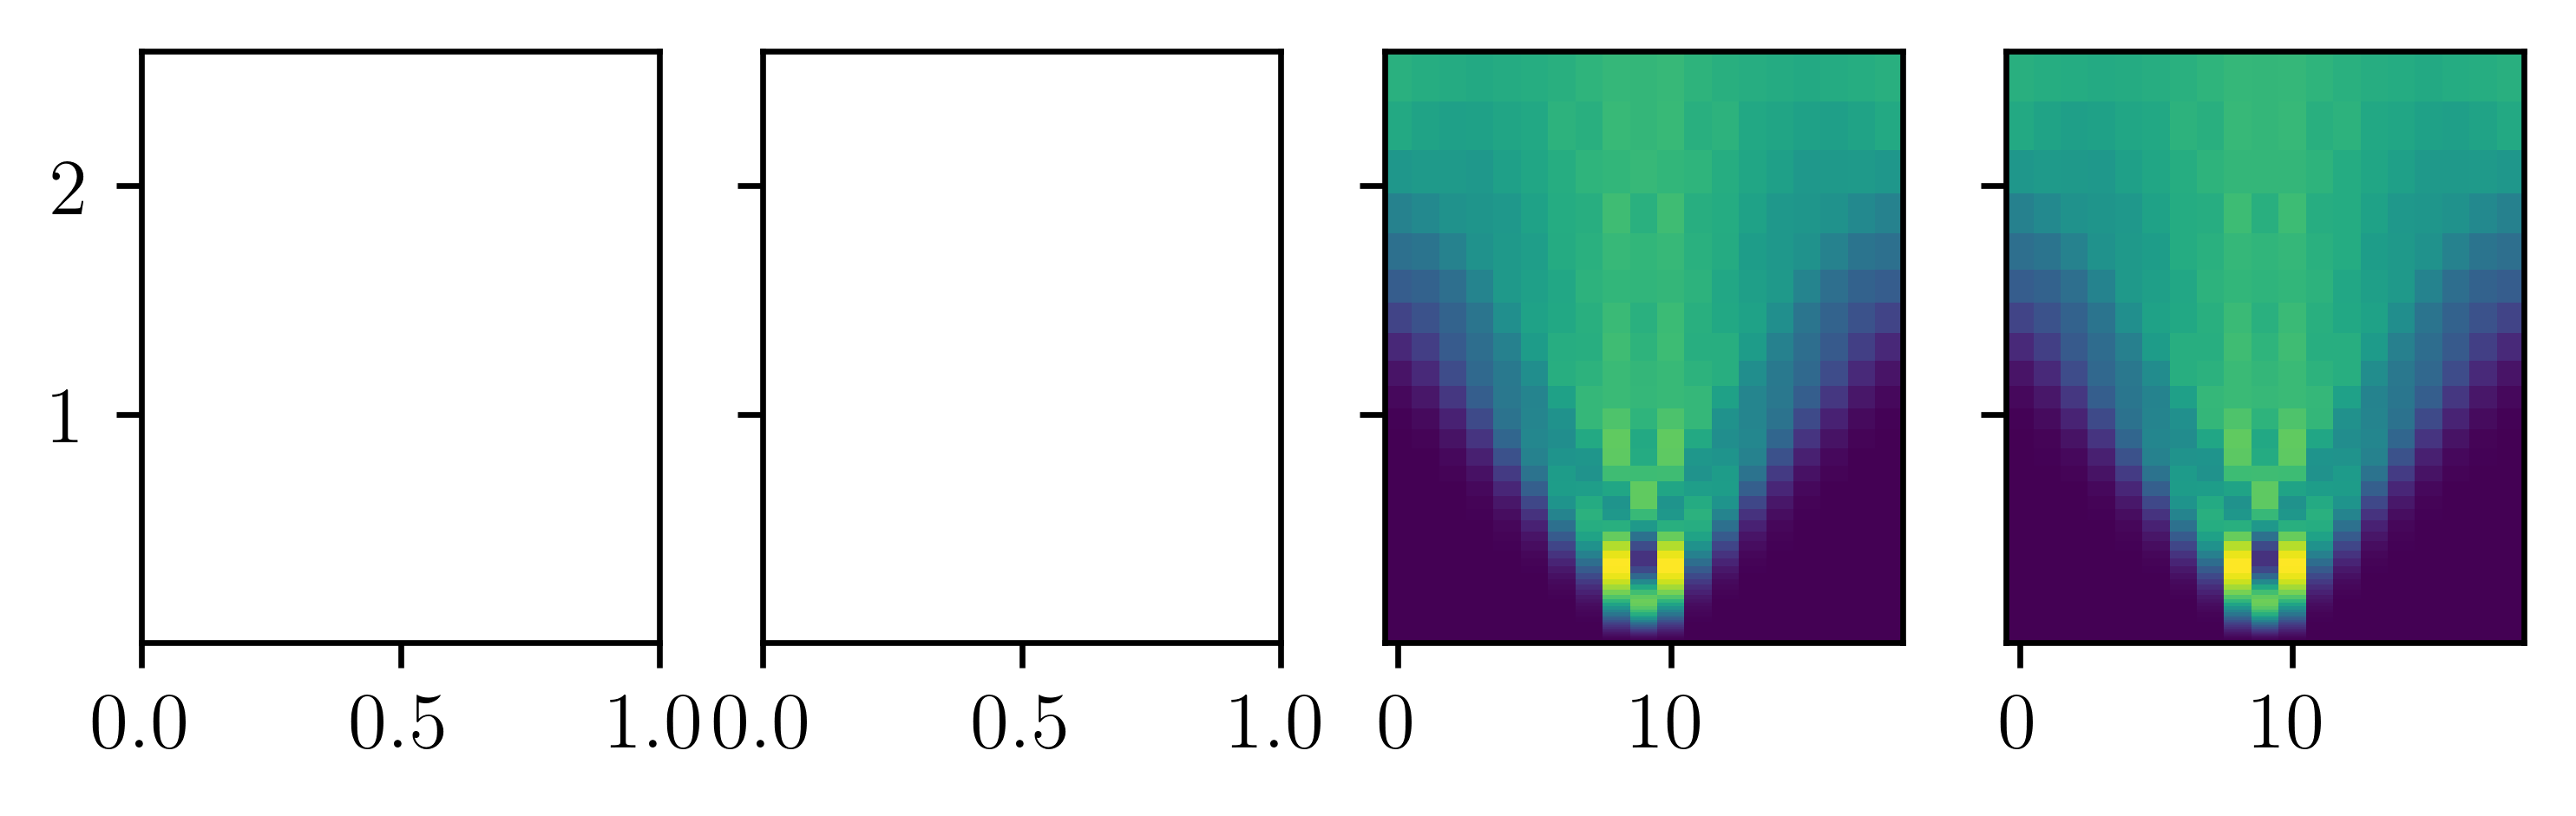

In [50]:
fig, axs = plt.subplots(1, 4,figsize=set_size(subplots=(1,4)),sharey=True,dpi=600)

axs[2].pcolormesh(range(0,N),T[0:85],res_xx[0:85,:],cmap="viridis")
axs[3].pcolormesh(range(0,N),T[0:85],res_xx_nn[0:85,:],cmap="viridis")
#plt.subplots_adjust(wspace=0.05, hspace=0.05)

## Temporal

In [51]:
popt_xx = []
perr_xx = []
tfitmax = [45,45,35,35,25,25,15,10,10,10]
tfitmin = [0,0,0,0,0,0,0,0,0,0]
tmin = [1,1,1,1,1,1,1,1,1]
for j in range(0,10):
    poptj, pcovj = curve_fit(model,T[tfitmin[j]:tfitmax[j]],red_xx[tfitmin[j]:tfitmax[j],j])
    popt_xx.append(poptj)
    perr_xx.append(np.sqrt(np.diag(pcovj)))

In [52]:
for j in range(0,9):
    print(popt_xx[j][0]*(9-j)**12)

91.27868703555377
91.56278587479916
82.61505041778192
84.68471479204614
81.52373281891703
84.0135526948576
83.25157186936939
105.39870038388962
80.03840407658824


In [53]:
popt_xx_nn = []
perr_xx_nn = []
tfitmax_nn = [60,60,60,60,55,55,50,50,50,50]
tfitmin_nn = [57,54,50,44,37,27,10,0,0,0]
for j in range(0,10):
    poptj_nn, pcovj_nn = curve_fit(model,T[tfitmin_nn[j]:tfitmax_nn[j]],red_xx_nn[tfitmin_nn[j]:tfitmax_nn[j],j])
    popt_xx_nn.append(poptj_nn)
    perr_xx_nn.append(np.sqrt(np.diag(pcovj_nn)))

In [54]:
for j in range(0,9):
    print(popt_xx_nn[j][0])

0.26633154860463826
1.3358857432060096
6.245934149295479
19.30637495495521
84.10003885416003
124.25634876538071
238.61963603295058
106.37351376689402
52.04608552559374


In [55]:
tcut_xx = np.zeros(8)
Tindx = []
for j in range(0,8):
    tcut_xx[j] = (popt_xx[j][0]/popt_xx_nn[j][0])**(1/(popt_xx_nn[j][1]-popt_xx[j][1]))
    print(tcut_xx[j])
    Tindx.append(np.argmin(np.abs(tcut_xx[j]-T)))

0.2704282534735529
0.21855979606676126
0.16729876786817377
0.12375490054901825
0.0840040777810576
0.05314947528704696
0.025875103545525524
0.012478705954761712


In [56]:
for j in range(0,10):
    print((popt_xx[j][1]-2)/2*100)

1.817630458777919
1.821746382226208
0.34378946505795316
0.6091856639576232
0.17600138681899136
0.42727178430896906
0.3099487161037695
2.005252725476425
-0.004539240466483463
-0.008593596205241916


In [57]:
for j in range(0,9):
    print((popt_xx[j][0]*(9-j)**12-16*5)/(16*5)*100)

14.098358794442218
14.453482343498953
3.2688130222273943
5.855893490057671
1.9046660236462822
5.016940868571993
4.064464836711732
31.748375479862023
0.0480050957352951


In [58]:
np.arange(0,N//2+1,1)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

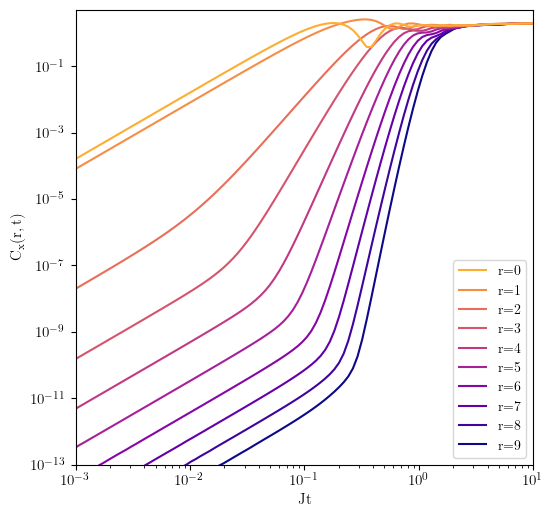

In [59]:
NUM_COLORS = N//2+2
cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
fig = plt.figure(figsize=set_size())
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)])
ax.set_xscale("log")
ax.set_yscale("log")
for j in range(0,N//2+1):
    ax.plot(T,red_xx[:,j],label="r={}".format(rvals[j]))
    #ax.plot(T,red_xx_nn[:,j])
    #if j <= 7:
    #    ax.plot(T[tfitmin[j]:],model(T[tfitmin[j]:],popt[j][0],popt[j][1]),color="black",alpha=0.8,ls="dashed")
    #    ax.plot(T[tfitmin_nn[j]:tfitmax_nn[j]],model(T[tfitmin_nn[j]:tfitmax_nn[j]],popt_nn[j][0],popt_nn[j][1]),color="black",alpha=0.8,ls="dashed")
    #    ax.scatter(tcut[j],model(tcut[j],popt[j][0],popt[j][1]),marker="x",c="black")

handles, labels = plt.gca().get_legend_handles_labels()
order = np.flip(np.arange(0,N//2+1,1))
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
ax.set_xlabel(r"Jt")
ax.set_ylabel(r"$\mathrm{C_x(r,t)}$")
ax.set_xlim(1e-3,10)
ax.set_ylim(1e-13,5)
plt.show()

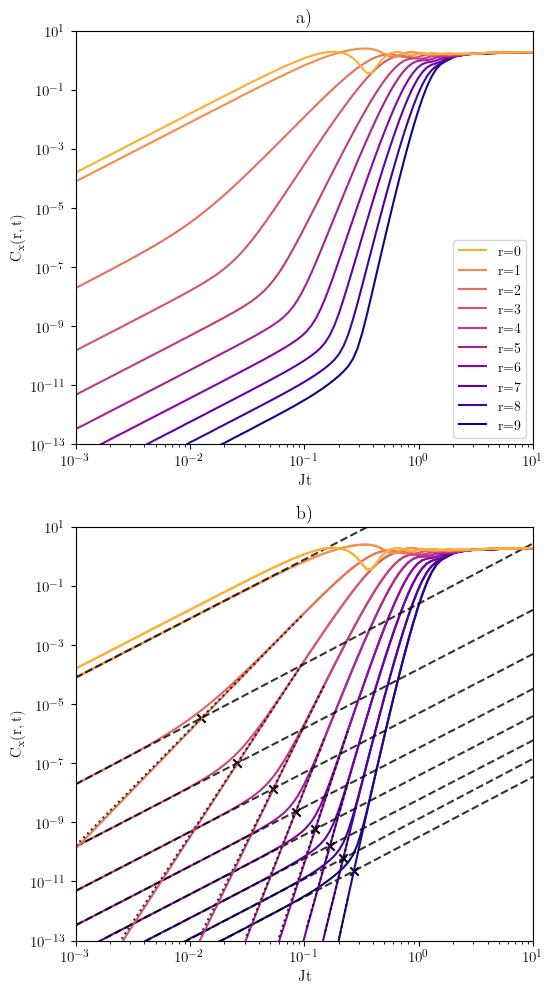

In [60]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=set_size(subplots=(2,1)))

NUM_COLORS = N//2+2
cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
ax1.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)])
ax1.set_xscale("log")
ax1.set_yscale("log")
for j in range(0,N//2+1):
    ax1.plot(T,red_xx[:,j],label="r={}".format(rvals[j]))
    #ax.plot(T,red_xx_nn[:,j])
    #if j <= 7:
    #    ax.plot(T[tfitmin[j]:],model(T[tfitmin[j]:],popt[j][0],popt[j][1]),color="black",alpha=0.8,ls="dashed")
    #    ax.plot(T[tfitmin_nn[j]:tfitmax_nn[j]],model(T[tfitmin_nn[j]:tfitmax_nn[j]],popt_nn[j][0],popt_nn[j][1]),color="black",alpha=0.8,ls="dashed")
    #    ax.scatter(tcut[j],model(tcut[j],popt[j][0],popt[j][1]),marker="x",c="black")

handles, labels = ax1.get_legend_handles_labels()
order = np.flip(np.arange(0,N//2+1,1))
ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
ax1.set_xlabel(r"Jt")
ax1.set_ylabel(r"$\mathrm{C_x(r,t)}$")
ax1.set_xlim(1e-3,10)
ax1.set_ylim(1e-13,10)
ax1.set_title("a)")



NUM_COLORS = N+4
cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
ax2.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)])
ax2.set_xscale("log")
ax2.set_yscale("log")
for j in range(0,N//2+1):
    ax2.plot(T,red_xx[:,j],label="r={}".format(rvals[j]))
    ax2.plot(T,red_xx_nn[:,j])
    if j <= 8:
        ax2.plot(T[tfitmin[j]:],model(T[tfitmin[j]:],popt_xx[j][0],popt_xx[j][1]),color="black",alpha=0.8,ls="dashed")
    if j <= 7:
        ax2.plot(T[tfitmin_nn[j]:tfitmax_nn[j]],model(T[tfitmin_nn[j]:tfitmax_nn[j]],popt_xx_nn[j][0],popt_xx_nn[j][1]),color="black",alpha=0.8,ls="dotted")
        ax2.scatter(tcut_xx[j],model(tcut_xx[j],popt_xx[j][0],popt_xx[j][1]),marker="x",c="black")

handles, labels = plt.gca().get_legend_handles_labels()
order = np.flip(np.arange(0,N//2+1,1))
#ax2.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
ax2.set_xlabel(r"Jt")
ax2.set_ylabel(r"$\mathrm{C_x(r,t)}$")
ax2.set_xlim(1e-3,10)
ax2.set_ylim(1e-13,10)
ax2.set_title("b)")
plt.savefig(figurepath/"temp_xx.png",format="png",bbox_inches='tight',dpi=600)
plt.show()

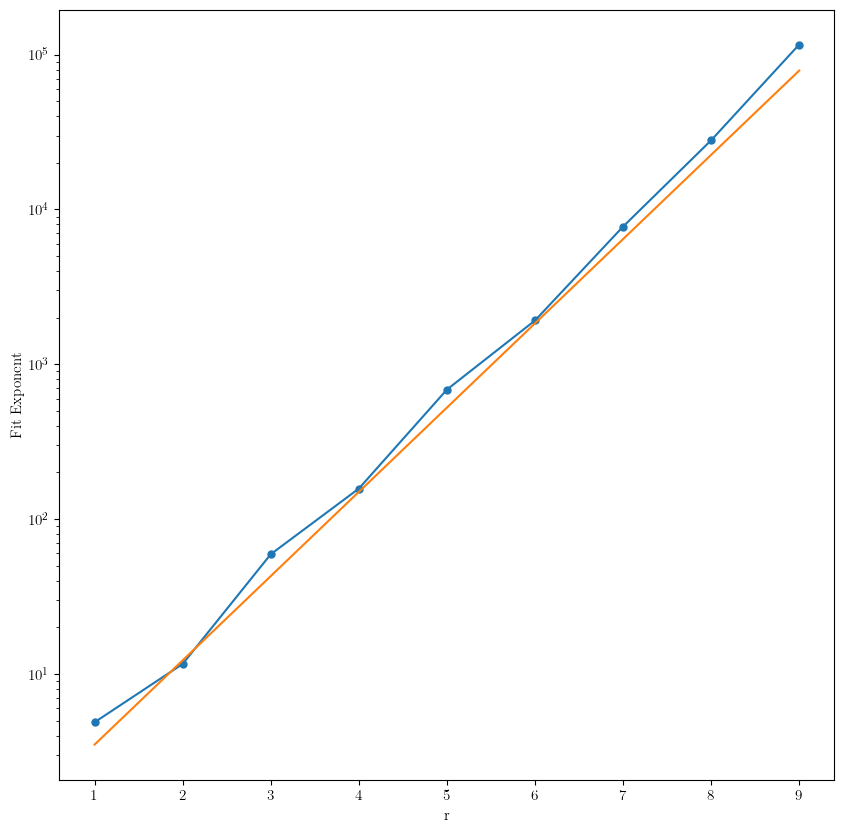

In [61]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
#ax.plot(rvals[0:9],[popt_xx[j][0] for j in range(0,9)],marker="o",ms=5)
ax.plot(rvals[0:9],[(popt_zz_nn[j][0]*np.math.factorial(rvals[j])**2)**0.5 for j in range(0,9)],marker="o",ms=5)
ax.plot(rvals[0:9],3.5**rvals[0:9])
ax.set_ylabel("Fit Exponent")
ax.set_yscale("log")
ax.set_xlabel("r")
plt.show()

In [62]:
popt_zz_nn

[array([ 0.10239085, 17.76571191]),
 array([ 0.48041229, 15.69194942]),
 array([ 2.36256732, 13.63712906]),
 array([ 7.0958643 , 11.64894964]),
 array([32.69908628,  9.82222675]),
 array([43.03176216,  7.86292802]),
 array([97.79629097,  5.90941662]),
 array([33.70630537,  4.01601137]),
 array([23.79596712,  1.91121305]),
 array([43.64605274,  1.88547593])]

In [63]:
(4/3*2*2)**2

28.444444444444443

## Spatial

In [64]:
ts1 = [0.001,0.005,0.01,0.025,0.05]
Tis1 = []
for t in ts1:
    Tis1.append(np.argmin(np.abs(T-t)))

ts2 = [0.01,0.025,0.05,0.1,0.25,0.5,1]
Tis2 = []
for t in ts2:
    Tis2.append(np.argmin(np.abs(T-t)))


/tmp/ipykernel_158678/1369915708.py:4: RuntimeWarning: divide by zero encountered in true_divide
  ax1.plot(rvals[0:10],5*16/rvals[0:10]**12 * T[ti]**2,color="red",ls="dashed",lw=0.5)
/tmp/ipykernel_158678/1369915708.py:21: RuntimeWarning: divide by zero encountered in true_divide
  ax2.plot(rvals[0:10],5*16/rvals[0:10]**12 * T[ti]**2,color="red",ls="dashed",lw=0.5)


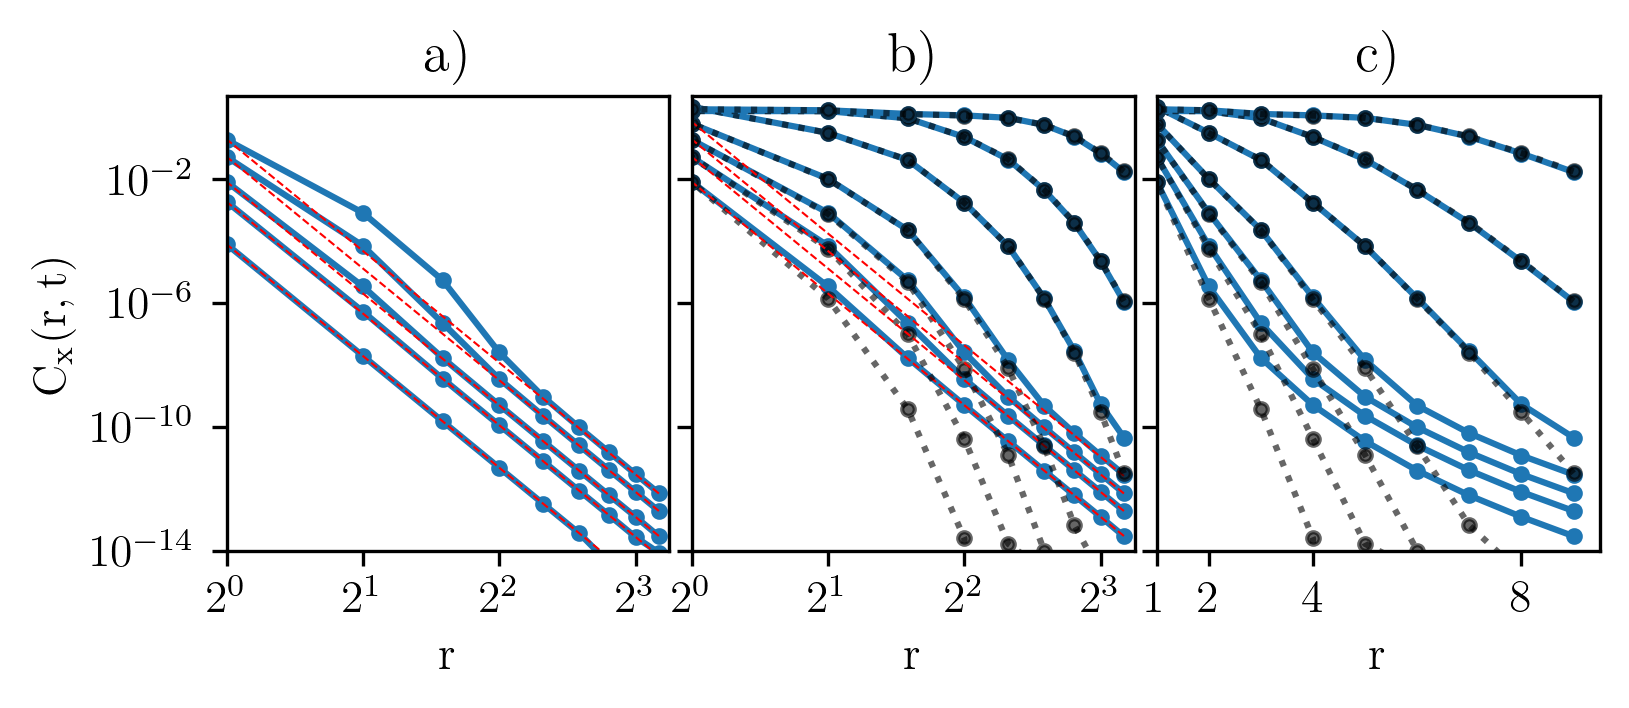

In [65]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=set_size(subplots=(1,3)),dpi=300,sharey=True)
for ti in Tis1:
    ax1.plot(rvals[0:10],red_xx[ti,:],label="t={:.2f}".format(T[ti]),color="C0",marker=".")
    ax1.plot(rvals[0:10],5*16/rvals[0:10]**12 * T[ti]**2,color="red",ls="dashed",lw=0.5)

ax1.set_xlabel("r")
ax1.set_xscale("log",base=2)
ax1.set_yscale("log")
ax1.set_ylabel(r"$\mathrm{C_x(r,t)}$")
ax1.set_ylim(1e-14,5)
ax1.set_xlim(1,N//2+0.5)
ax1.set_xticks([1,2,4,8])
ax1.set_title("a)")
#ax1.legend(loc="lower left")

ind = 0
for ti in Tis2:
    ax2.plot(rvals[0:10],red_xx[ti,:],label="t={:.2f}".format(T[ti]),color="C0",marker=".")
    ax2.plot(rvals[0:10],red_xx_nn[ti,:],ls="dotted",c="black",alpha=0.6,marker=".")
    if ind <= 3:
        ax2.plot(rvals[0:10],5*16/rvals[0:10]**12 * T[ti]**2,color="red",ls="dashed",lw=0.5)
        ind += 1

ax2.set_xlabel("r")
ax2.set_xscale("log",base=2)
ax2.set_yscale("log")
ax2.set_xlim(1,N//2+0.5)
ax2.set_xticks([1,2,4,8])
ax2.set_title("b)")



for ti in Tis2:
    ax3.plot(rvals[0:10],red_xx[ti,:],label="t={:.2f}".format(T[ti]),color="C0",marker=".")
    ax3.plot(rvals[0:10],red_xx_nn[ti,:],ls="dotted",c="black",alpha=0.6,marker=".")
    
ax3.set_xlabel("r")
ax3.set_yscale("log")
ax3.set_xlim(1,N//2+0.5)
ax3.set_xticks([1,2,4,8])
ax3.set_title("c)")


plt.subplots_adjust(wspace=0.05, hspace=0.05)

plt.show()

# Combined figures

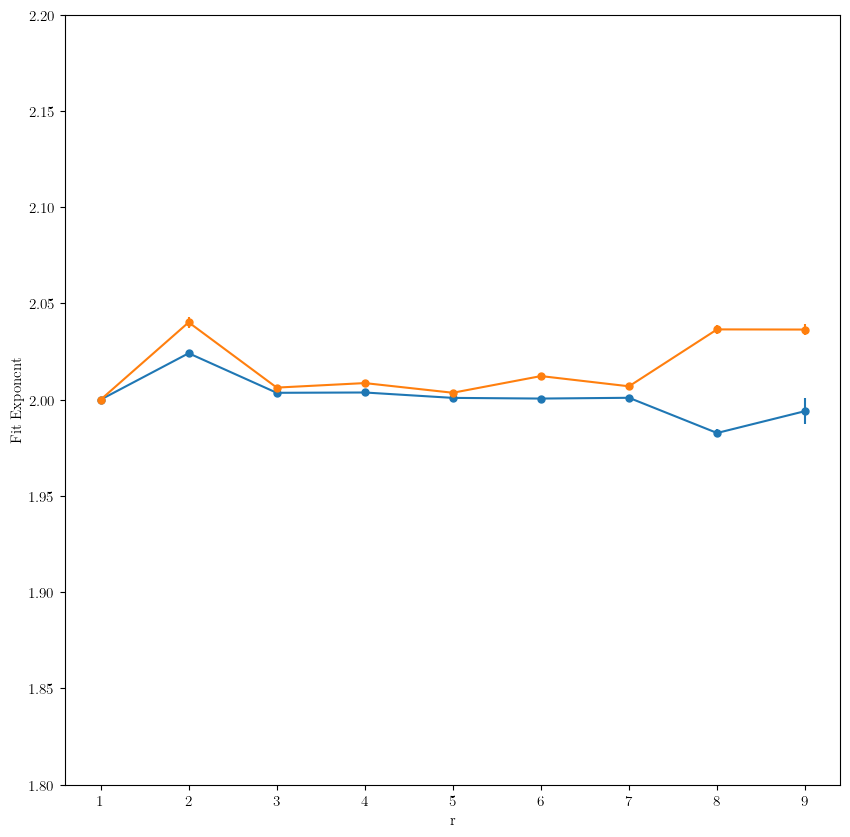

In [66]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.errorbar(rvals[0:9],[popt_zz[j][1] for j in range(0,9)],yerr=[perr_zz[j][1] for j in range(0,9)],marker="o",ms=5)
#ax.errorbar(rvals[0:8],[popt_zz_nn[j][1] for j in range(0,8)],yerr=[perr_zz_nn[j][1] for j in range(0,8)],marker="o",ms=5)
ax.errorbar(rvals[0:9],[popt_xx[j][1] for j in range(0,9)],yerr=[perr_xx[j][1] for j in range(0,9)],marker="o",ms=5)
#ax.plot(rvals[0:8],[popt_xx_nn[j][1] for j in range(0,8)],marker="o",ms=5)
ax.set_ylabel("Fit Exponent")
ax.set_xlabel("r")
plt.ylim(1.8,2.2)
plt.show()

In [67]:
rvals

array([9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

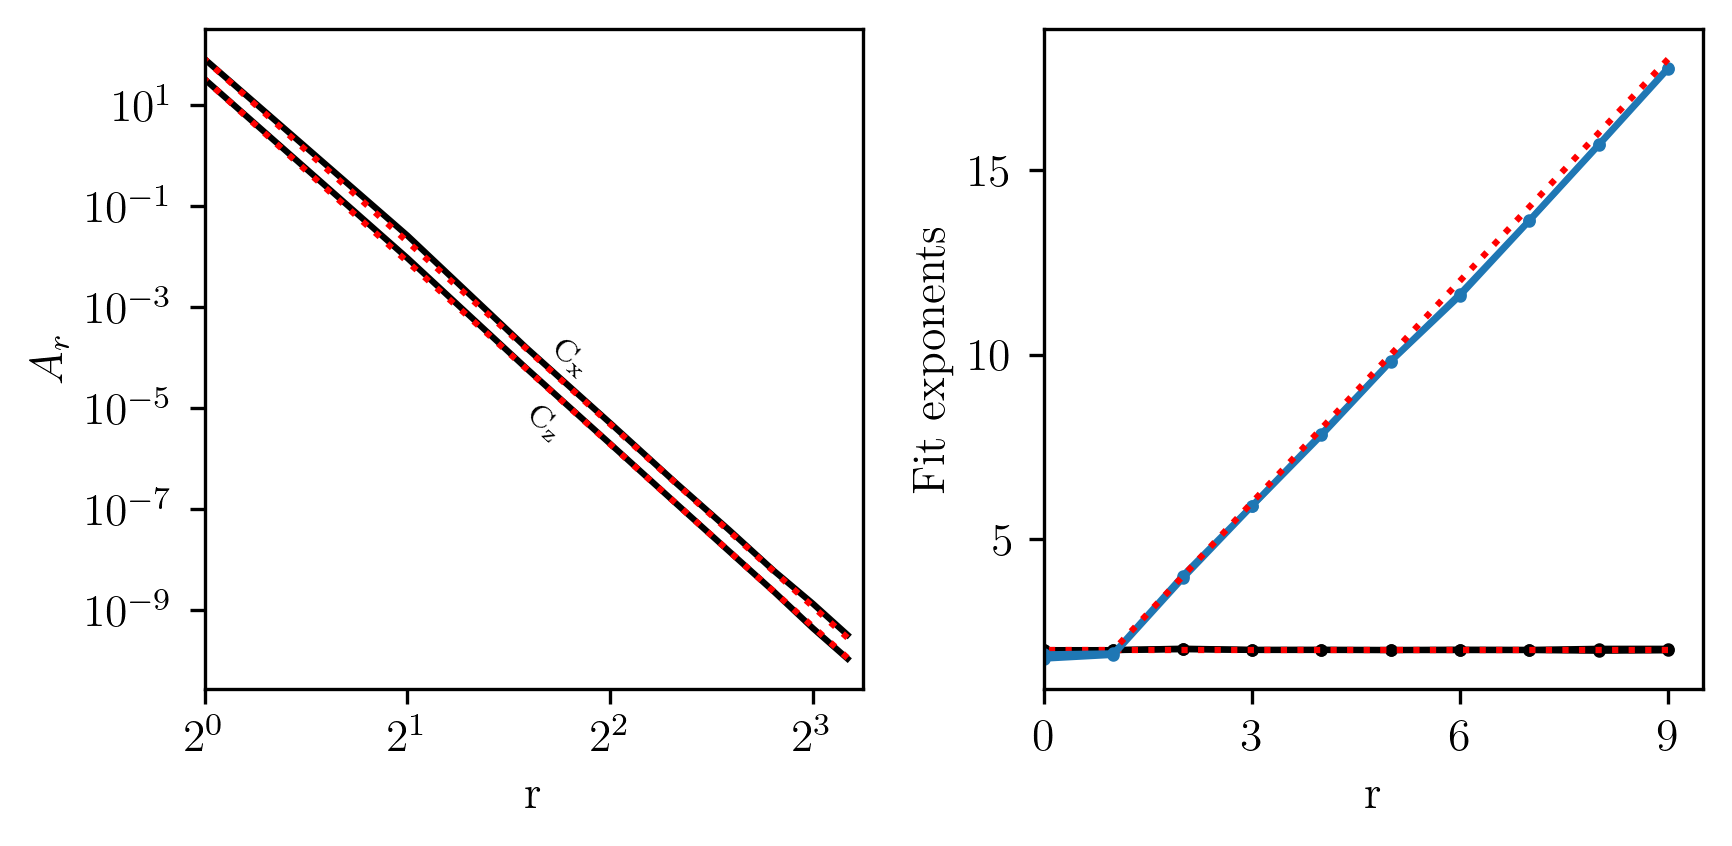

In [68]:
fig, (ax1, ax3) = plt.subplots(1, 2,figsize=set_size(subplots=(1,2)),dpi=300)

ax1.plot(rvals[0:9],[popt_zz[j][0] for j in range(0,9)],c="black")
ax1.plot(rvals[0:9],32/rvals[0:9]**12,ls="dotted",c="red")
ax1.plot(rvals[0:9],[popt_xx[j][0] for j in range(0,9)],c="black")
ax1.plot(rvals[0:9],5*16/rvals[0:9]**12,ls="dotted",c="red")
ax1.set_yscale("log")
ax1.set_xscale("log",base=2)
ax1.set_xticks([1,2,4,8])
ax1.set_xlim(1,N//2+0.5)
ax1.set_xlabel("r")
ax1.set_ylabel(r"$A_r$")
ax1.text(3.5,1e-4,r"$\mathrm{C_x}$",rotation=np.arctan(-0.9)/(2*np.pi)*360,ha="center",va="center",fontsize="x-small")
ax1.text(3.2,5e-6,r"$\mathrm{C_z}$",rotation=np.arctan(-0.9)/(2*np.pi)*360,ha="center",va="center",fontsize="x-small")



# ax2.plot(rvals[0:9],[popt_zz_nn[j][0] for j in range(0,9)],c="black")

# #ax2.plot(rvals[0:8],32/rvals[0:8]**12,ls="dotted",c="red")
# ax2.plot(rvals[0:9],[popt_xx_nn[j][0] for j in range(0,9)],c="black")
# #ax2.plot(rvals[0:8],5*16/rvals[0:8]**12,ls="dotted",c="red")
# ax2.set_yscale("log")
# ax2.set_xscale("log",base=2)
# ax2.set_xticks([1,2,4,8])
# ax2.set_xlim(1,N//2+0.5)
# ax2.set_xlabel("r")
# ax2.set_ylabel(r"$B_r$")


ax3.plot(rvals[0:10],[popt_zz[j][1] for j in range(0,10)],marker="o",ms=2,c="black")
ax3.plot(rvals[0:10],[popt_xx[j][1] for j in range(0,10)],marker="o",ms=2,c="black")
ax3.plot(rvals[0:10],2*np.ones(10),ls="dotted",c="red")

ax3.plot(rvals[0:10],[popt_zz_nn[j][1] for j in range(0,10)],marker="o",ms=2,c="C0")
ax3.plot(rvals[0:10],[popt_xx_nn[j][1] for j in range(0,10)],marker="o",ms=2,c="C0")
ax3.plot(rvals[0:9],2*rvals[0:9],ls="dotted",c="red")
ax3.set_ylabel("Fit exponents")
ax3.set_xlabel("r")
ax3.set_xlim(0,N//2+0.5)
ax3.set_xticks([0,3,6,9])

plt.tight_layout()
plt.savefig(figurepath/"fit_params_all.png",format="png",bbox_inches='tight',dpi=600)
plt.show()

In [69]:
for j in range(len(popt_xx)):
    print((popt_xx[j][1]-popt_zz[j][1])/(popt_xx[j][1]+popt_zz[j][1])*2*100)

2.1023646129541973
2.677906815867416
0.2978087074683528
0.581983107374229
0.1329617521213219
0.24363081464505199
0.13483518659781532
0.790277178431336
-0.0009901149258800185
-0.004658487195898656


In [70]:
for j in range(len(popt_xx)):
    print((popt_xx_nn[j][1]-popt_zz_nn[j][1])/(popt_xx_nn[j][1]+popt_zz_nn[j][1])*2*100)

-0.17352820311903897
-0.16782165277954922
-0.10640290501534411
-0.4651260946185076
-0.08926908539648677
-0.6680795794156646
-0.12907236782279
-1.920384475208383
-2.106828055642425
-6.352977343747936


In [71]:
popt_xx_nn

[array([ 0.26633155, 17.73491011]),
 array([ 1.33588574, 15.66563701]),
 array([ 6.24593415, 13.62262647]),
 array([19.30637495, 11.59489305]),
 array([84.10003885,  9.81346245]),
 array([124.25634877,   7.81057229]),
 array([238.61963603,   5.90179412]),
 array([106.37351377,   3.939622  ]),
 array([52.04608553,  1.87136682]),
 array([73.74847278,  1.76937985])]

In [72]:
popt_zz_nn

[array([ 0.10239085, 17.76571191]),
 array([ 0.48041229, 15.69194942]),
 array([ 2.36256732, 13.63712906]),
 array([ 7.0958643 , 11.64894964]),
 array([32.69908628,  9.82222675]),
 array([43.03176216,  7.86292802]),
 array([97.79629097,  5.90941662]),
 array([33.70630537,  4.01601137]),
 array([23.79596712,  1.91121305]),
 array([43.64605274,  1.88547593])]